In [1]:
import os
os.getcwd()

'E:\\researches\\MusicVAE'

In [2]:
os.chdir('E:\\researches\\MusicVAE\\src')

In [3]:
from src.params import *
from src.model import VariationalAutoencoder
import matplotlib.pyplot as plt
from src.midi_builder_new import MidiBuilderNew
from src.new_model import VAECell

In [4]:
m_key_count

5

In [5]:
from data_utils import MidiDataset, BarTransform
from torch.autograd import Variable #deprecated!!!

In [6]:
builder = MidiBuilderNew()

In [7]:
''' 
Create model and load state dict from path
'''
def loadModel(path):
    model = VAECell(latent_features)
    model.load_state_dict(torch.load(path, map_location=device))
    model.eval()

    return model

In [8]:
transform = BarTransform(bars=totalbars, note_count=NUM_PITCHES)
midi_dataset = MidiDataset(csv_file='../piano_rolls_a_small_fraction.csv', transform = transform)
dataset_size = len(midi_dataset)           #number of musics on dataset
test_size = int(test_split * dataset_size) #test size length
train_size = dataset_size - test_size      #train data length
train_dataset, test_dataset = random_split(midi_dataset, [train_size, test_size])
test_loader = DataLoader(test_dataset, shuffle=shuffle, batch_size=batch_size, num_workers=1)#, sampler=test_sampler)


In [9]:
model = loadModel('../records/net_Apr_18_5_chord.pt')
model = model.to(device)

Use attention type dot


In [10]:
x = next(iter(test_loader))
x = Variable(x['piano_rolls'].type('torch.FloatTensor'))

x = x.to(device)

#model.set_scheduled_sampling(1.)  # Please use teacher forcing for validations
outputs = model(x)

z_horizontal tensor([[ 0.8317, -0.5569,  2.2578,  0.0159, -2.3372, -0.3233, -0.5695,  0.8427,
          0.6723, -1.7853,  0.9544,  1.9434,  0.3816,  0.6628,  0.0856,  1.6221,
         -1.6711,  2.1328,  3.2385,  1.2737, -1.9346,  0.4649,  1.5778, -0.7846,
         -2.4909, -1.2249, -0.0289, -2.3465, -0.9539,  0.9795,  0.8781, -0.3350],
        [-0.8300, -1.8439,  1.7051, -0.1746, -0.7465, -0.3920, -0.7438, -0.2267,
          1.1593, -0.4556,  2.8738,  1.5855, -0.8166,  0.0535,  0.7800,  1.9596,
          0.1093,  0.8325,  3.0190,  1.2932,  0.0376, -0.9011, -0.5382, -2.1289,
         -3.0444,  0.5532,  1.1771, -2.4773,  0.5483, -0.8426, -1.3272,  1.5834],
        [ 0.0790, -0.6107,  2.7118, -0.3075, -2.8442, -0.3086, -0.5715,  0.3159,
          1.3825, -0.2045,  1.4704,  0.2071,  0.7586,  0.4239,  0.7353,  1.1834,
         -0.4597,  1.0313,  2.6249, -0.2240, -1.6803,  0.9097,  0.3740, -2.7329,
         -1.8189,  0.4084,  0.8993, -0.4529, -1.2561, -0.9024, -0.0779,  0.3101],
        [ 0.

In [11]:
x_hat = outputs['multi_notes']
x = x.to("cpu")
x_hat = x_hat.to("cpu")

In [12]:
x_hat.shape

torch.Size([40, 256, 5, 61])

In [13]:
multi_notes_np = x_hat.detach().numpy()

In [14]:
x_hat[0,0,0,:]

tensor([8.9964e-04, 3.1673e-02, 4.0537e-03, 4.4018e-02, 6.2040e-03, 2.8818e-02,
        1.2633e-02, 8.4904e-03, 1.8524e-02, 7.2297e-02, 3.0865e-02, 4.6206e-02,
        7.1815e-03, 3.9120e-01, 1.3561e-02, 6.2515e-02, 9.1323e-03, 1.3290e-02,
        2.4772e-02, 5.4849e-03, 2.2090e-02, 2.1391e-02, 1.0369e-02, 1.6638e-02,
        2.6151e-03, 4.0518e-02, 2.1226e-03, 1.0669e-02, 6.1803e-05, 6.4269e-03,
        8.5604e-03, 2.9681e-03, 4.2335e-03, 3.3901e-03, 2.4502e-03, 1.5479e-03,
        3.4677e-04, 5.1787e-03, 4.1628e-04, 1.4915e-03, 2.3039e-04, 8.9532e-04,
        5.7767e-04, 2.0083e-04, 2.8047e-04, 5.9195e-04, 3.6682e-05, 2.3648e-04,
        9.5822e-05, 5.6798e-04, 7.4931e-05, 4.9944e-05, 7.2665e-05, 1.0828e-04,
        1.2616e-04, 3.7040e-05, 7.9146e-05, 6.9583e-05, 9.8501e-05, 1.2169e-04,
        1.4009e-04], grad_fn=<SliceBackward>)

In [18]:
seq = multi_notes_np[0]
midi_out = np.zeros((seq.shape[0],seq.shape[2]))
print(midi_out.shape)
for j in range(5):
    x_j_np = seq[:, j, :]
    row_maxes = x_j_np.max(axis=1).reshape(-1, 1)
    midi_out_j = np.where(x_j_np == row_maxes, 1, 0)
    midi_out += midi_out_j

(256, 61)


In [19]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

In [20]:
midi_out

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 5., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 5., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 5., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 5., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0

In [21]:
x_hat.shape

torch.Size([40, 256, 5, 61])

In [22]:
def showReconstructionsMultiNotes(multi_notes : torch.Tensor, x : torch.Tensor):
    '''
    :param multi_notes:  reconstructed multinotes
    :param x: original notes
    :return:
    '''
    multi_notes_np = x_hat.detach().numpy()


    for i, seq in enumerate(multi_notes_np):
        midi_out = np.zeros((seq.shape[0],seq.shape[2]))
        #print(midi_out.shape)
        for j in range(m_key_count):
            x_j_np = seq[:, j, :]
            row_maxes = x_j_np.max(axis=1).reshape(-1, 1)
            midi_out_j = np.where(x_j_np == row_maxes, 1, 0)
            midi_out += midi_out_j
        
        midi_out = midi_out.clip(0, 1)
        if np.sum(midi_out[:, :-1]) == 0:
            print("Midi: {} is all silent".format(i))
            continue
        
        midi = builder.midi_from_piano_roll(midi_out[:,:-1]) # Select all notes but the silent one
        plt.figure(figsize=(10, 3))
        plt.title("Midi {}".format(i))

        builder.plot_midi(midi)
        plt.savefig("../midi/img_midi_{}.png".format(i))

        midi.write('../midi/{}.mid'.format(i))
        
    exit()
    # Compare to originals
    x_np = x.detach().numpy()
    
    
    for i, seq in enumerate(x_np):
        midi_out = seq

        if np.all(midi_out[:, -1]):
            print("Midi: {} is all silent".format(i))
            continue

        midi = builder.midi_from_piano_roll(midi_out[:, :-1])  # Select all notes but the silent one
        plt.figure(figsize=(10, 3))
        plt.title("Orig Midi {}".format(i))

        builder.plot_midi(midi)
        plt.savefig("../midi/img_midi_{}_orig.png".format(i))

        midi.write('../midi/{}_orig.mid'.format(i))

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


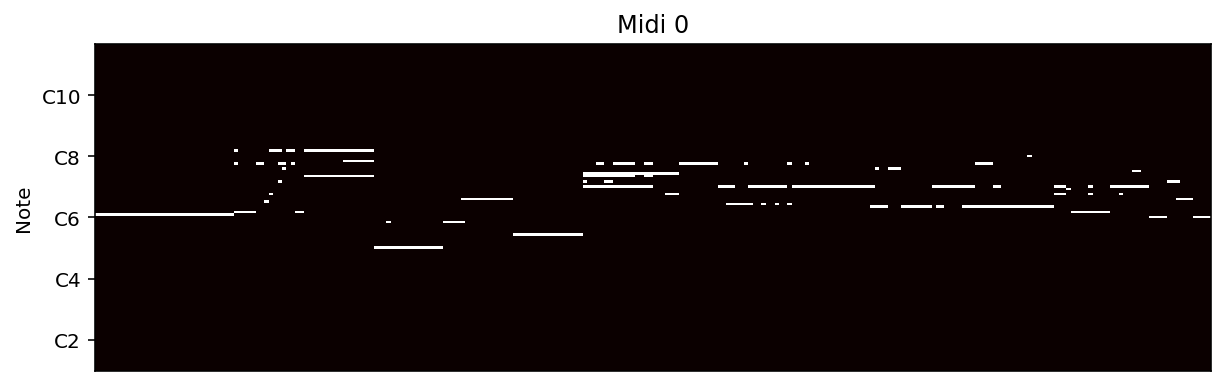

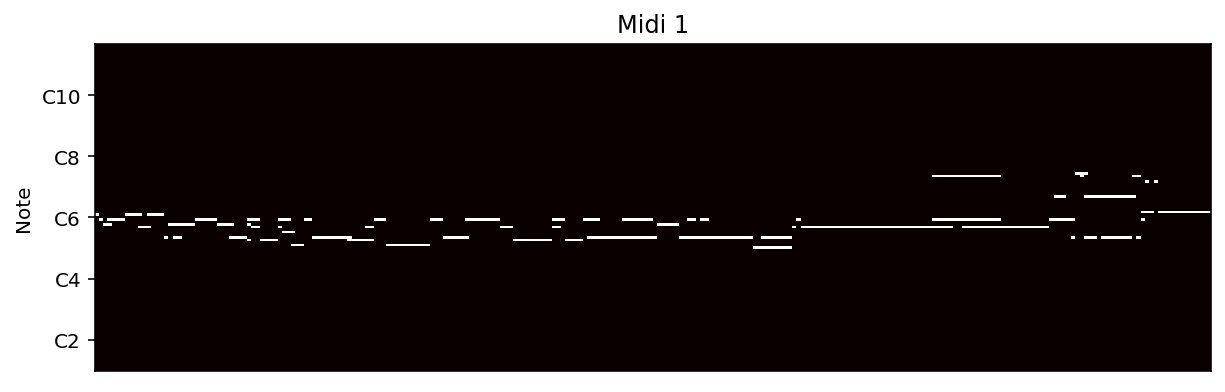

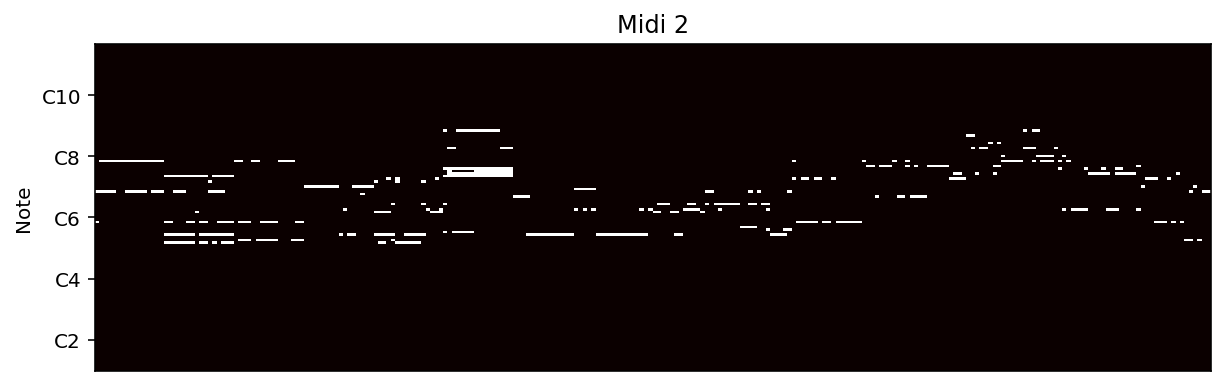

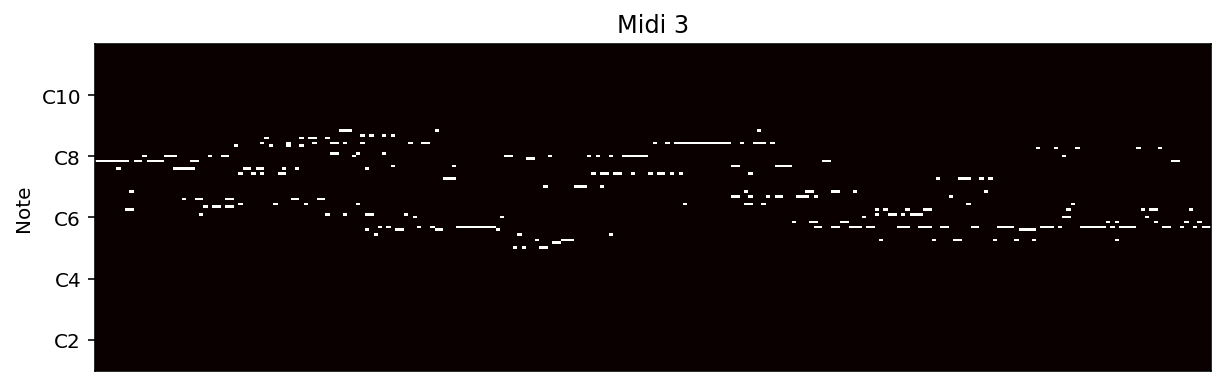

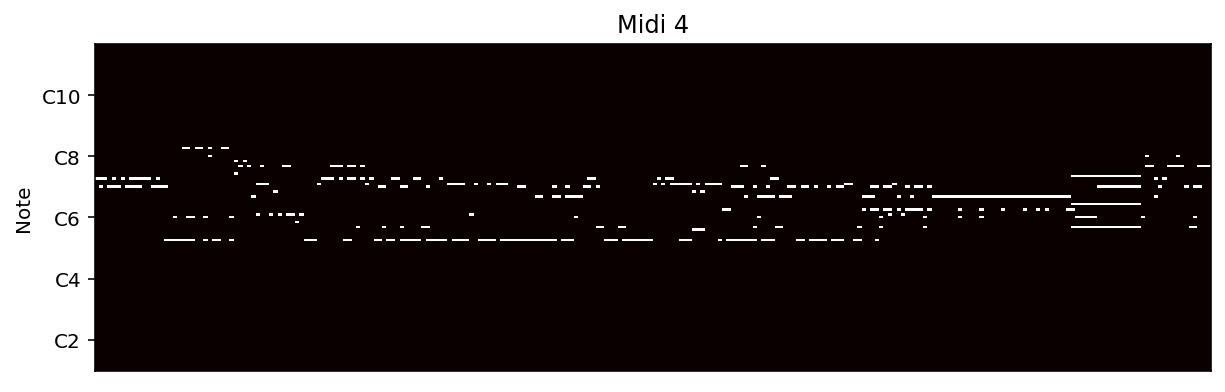

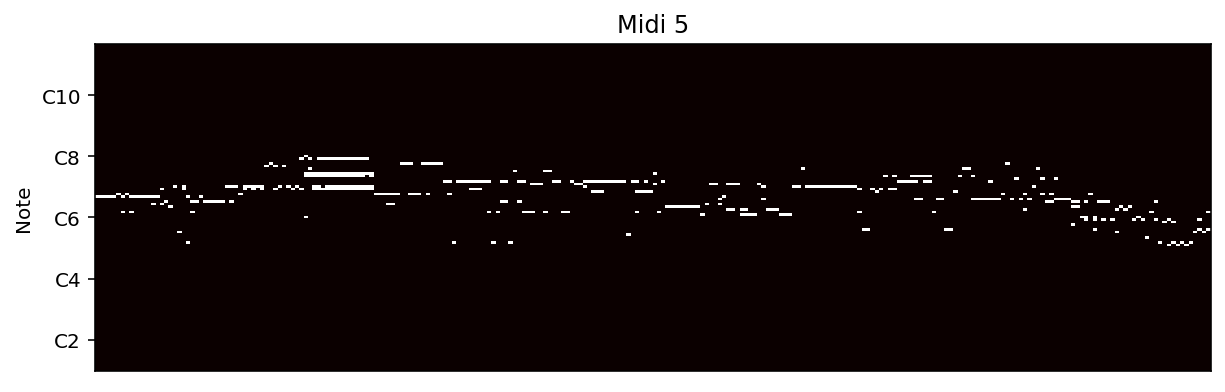

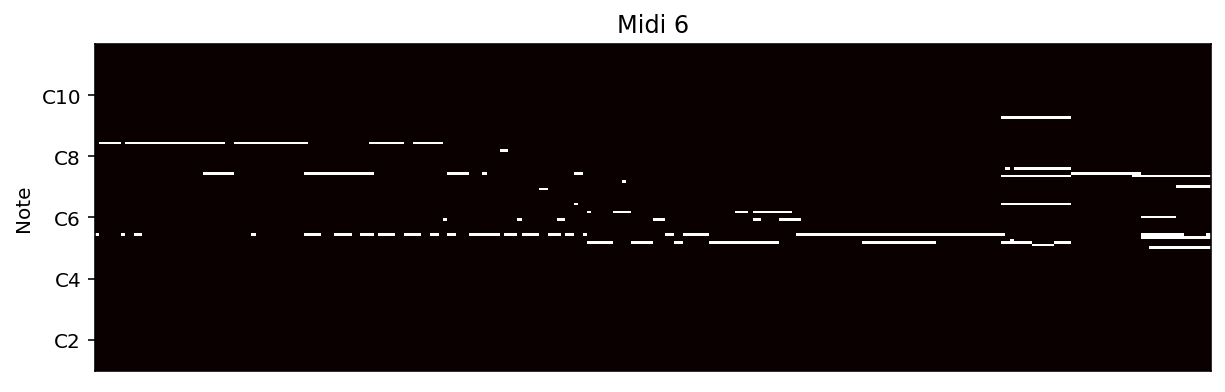

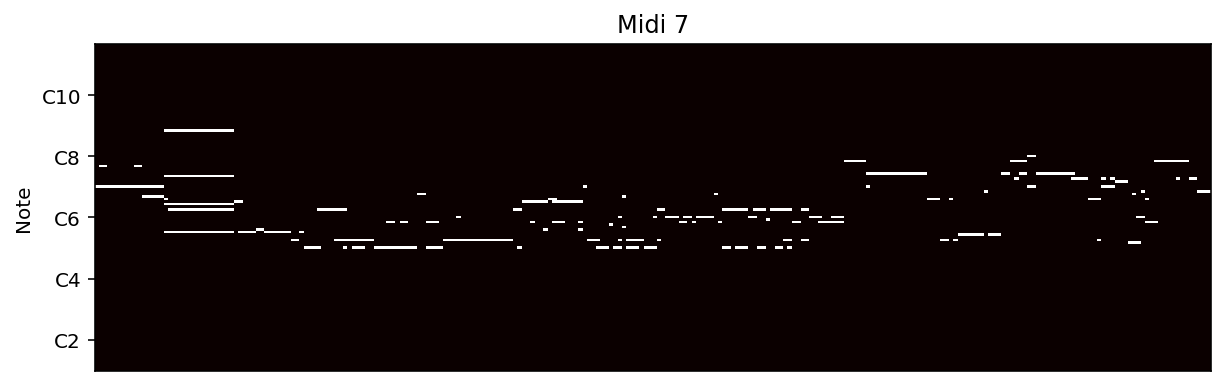

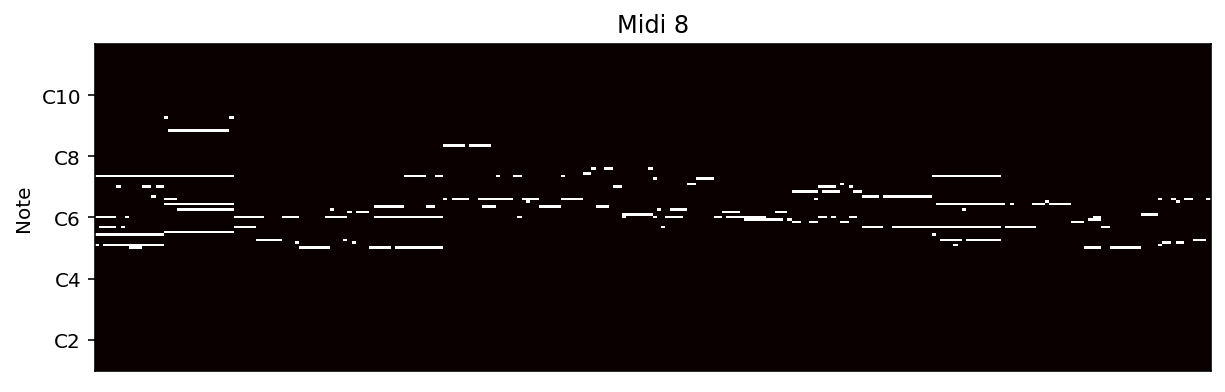

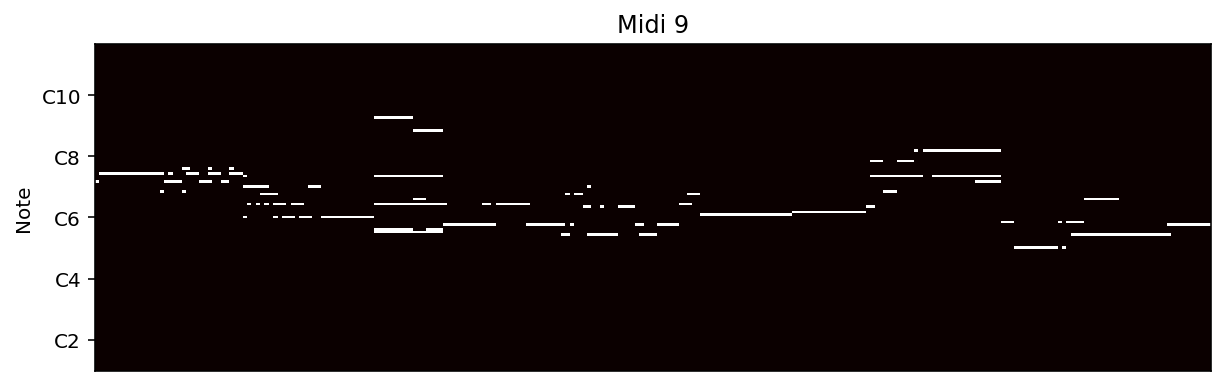

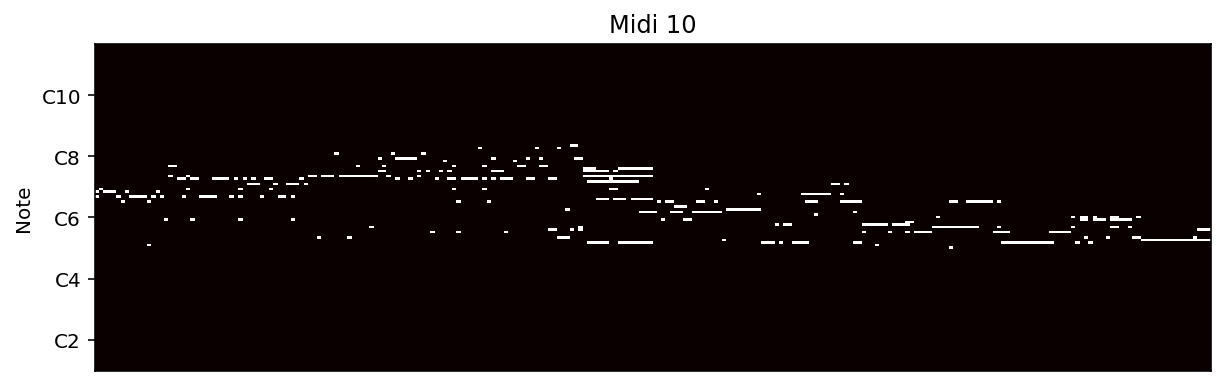

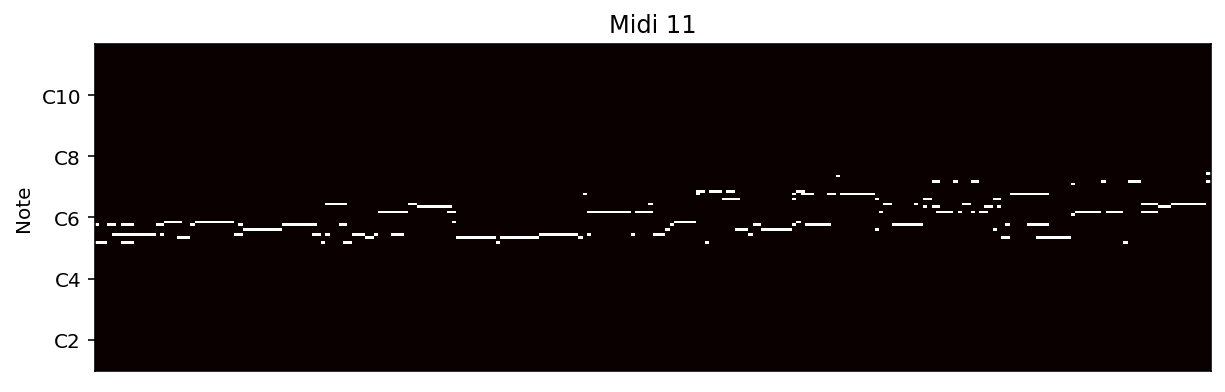

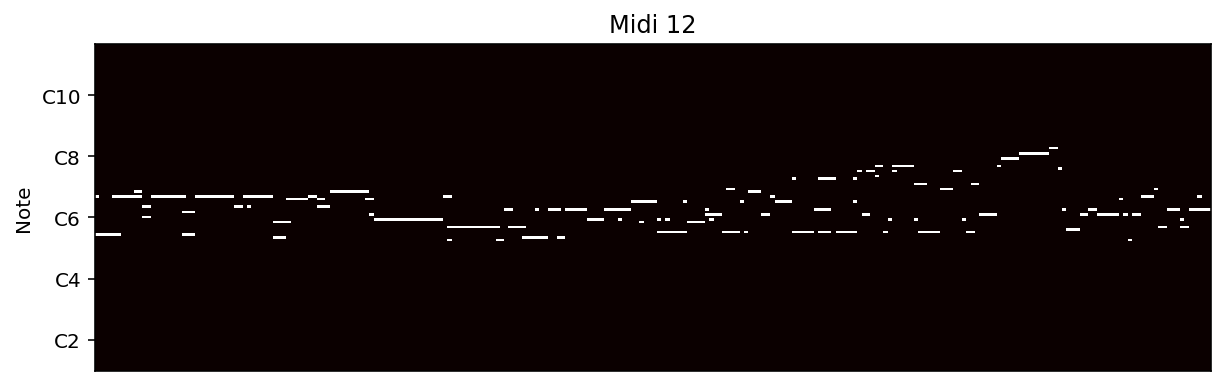

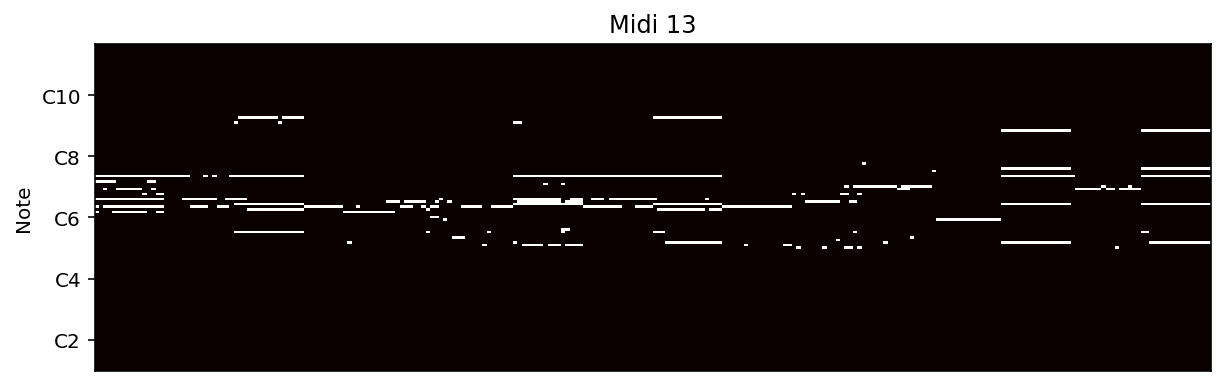

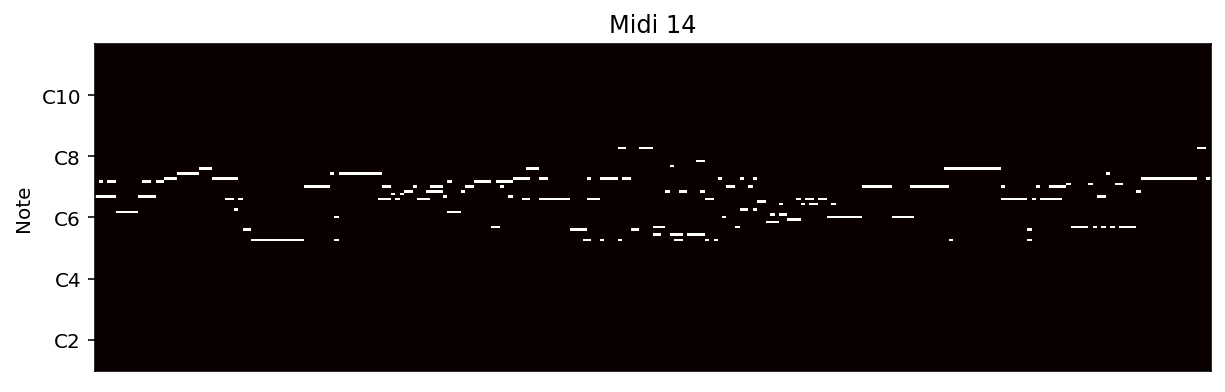

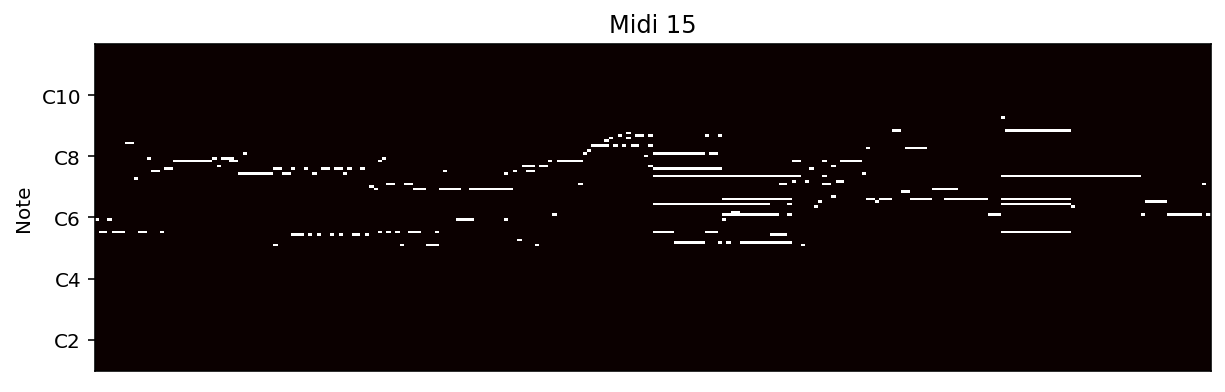

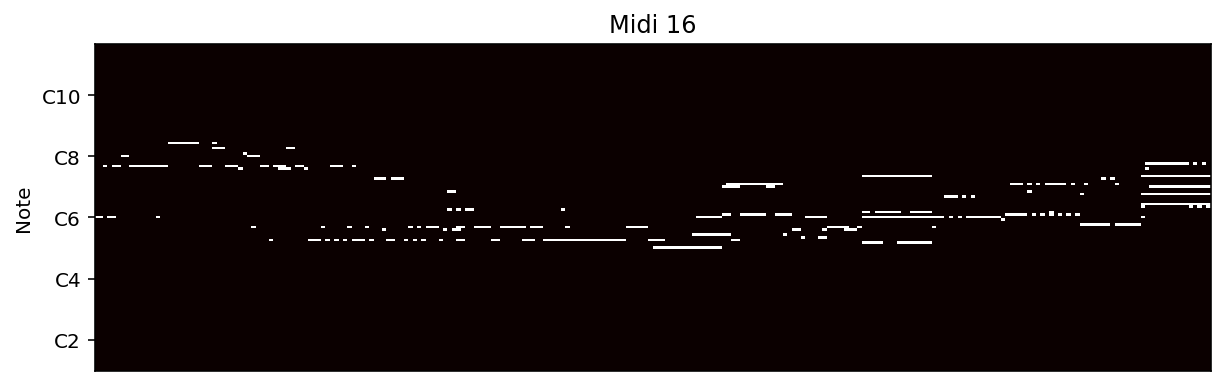

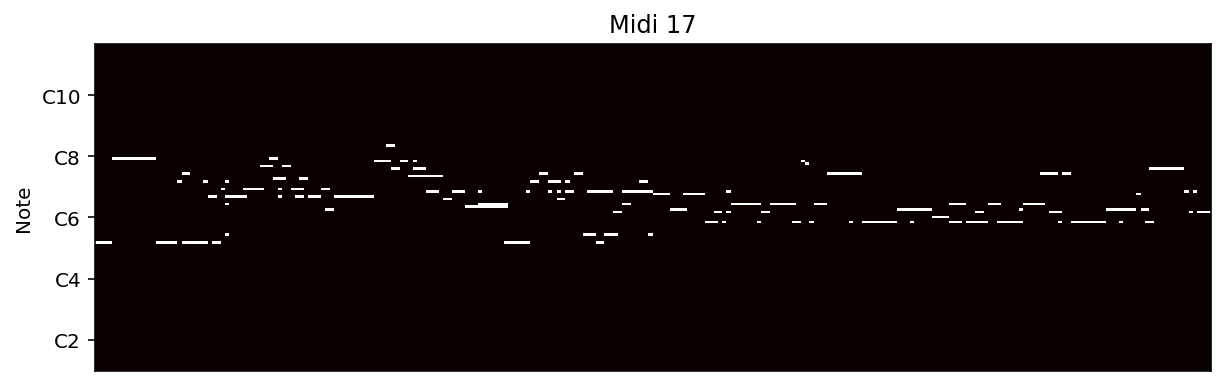

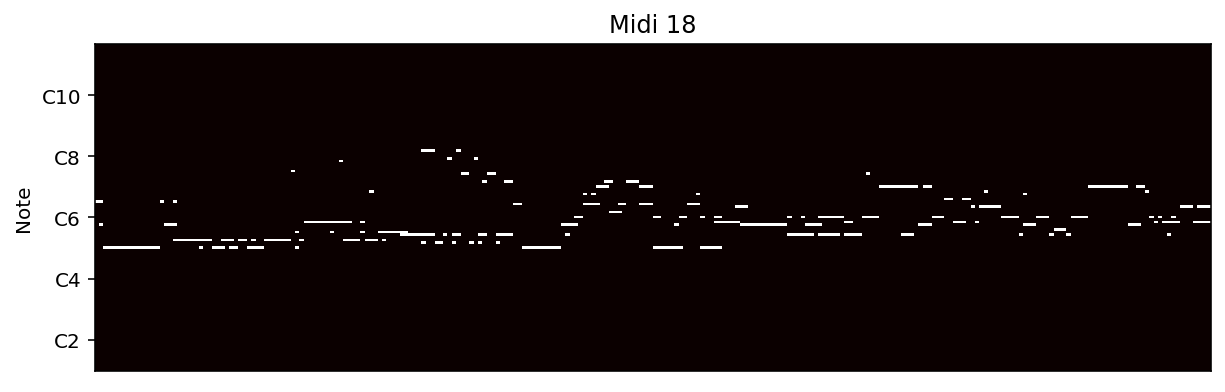

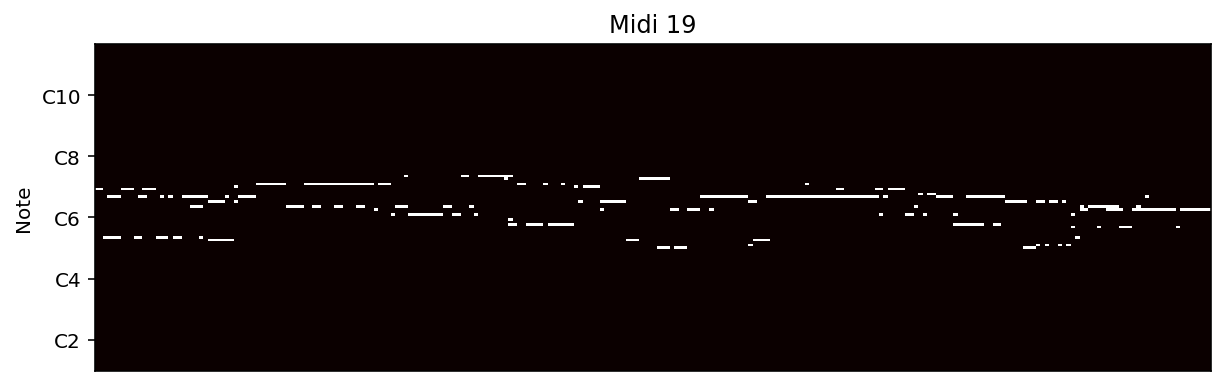

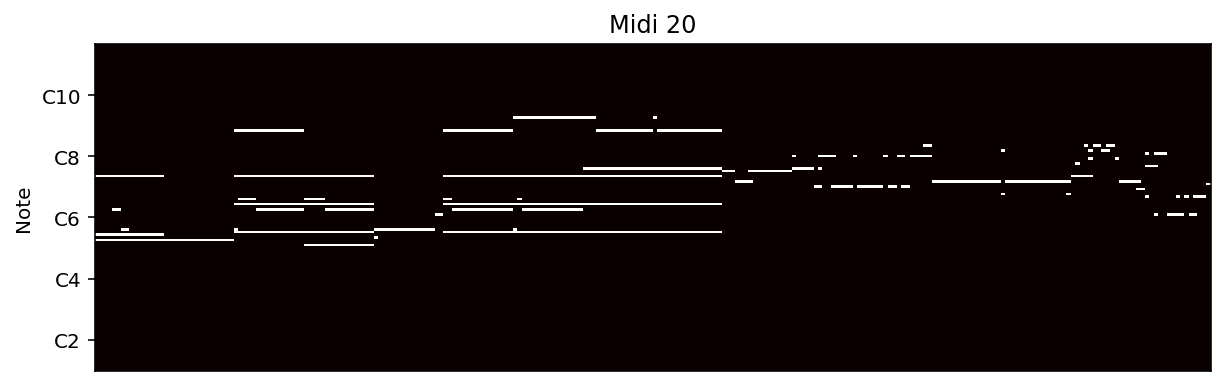

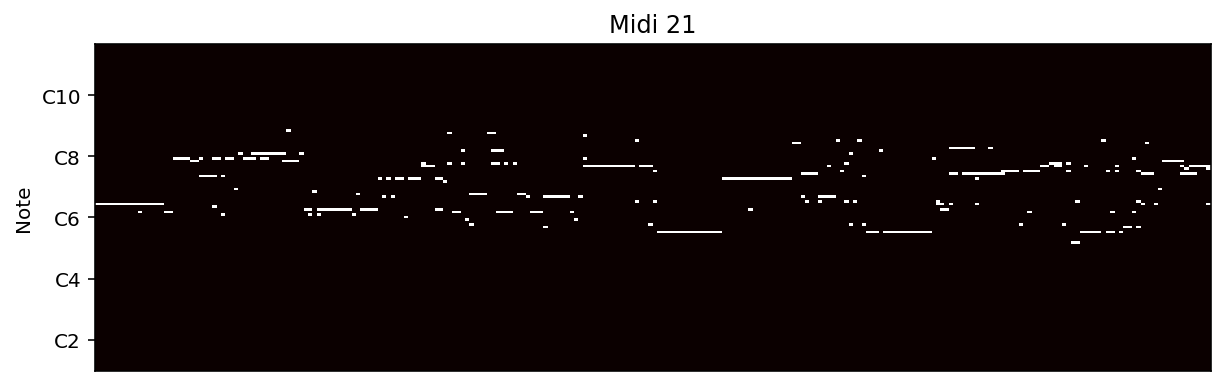

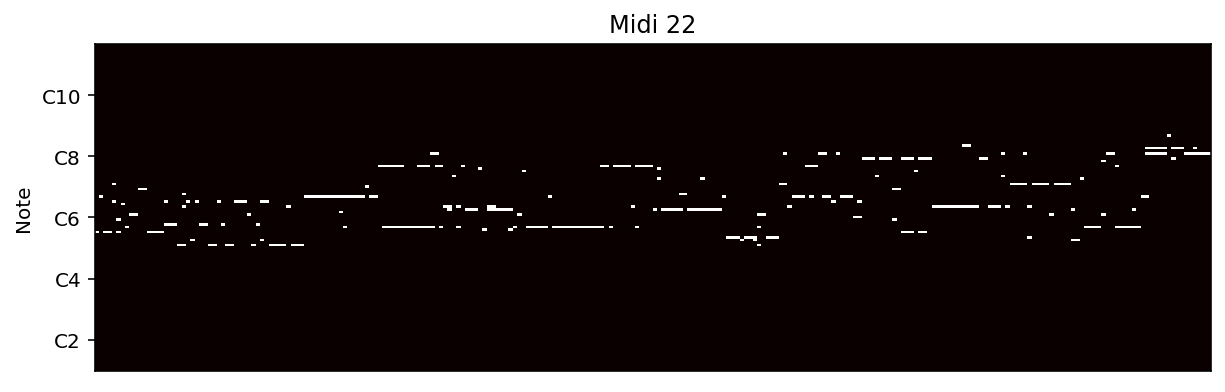

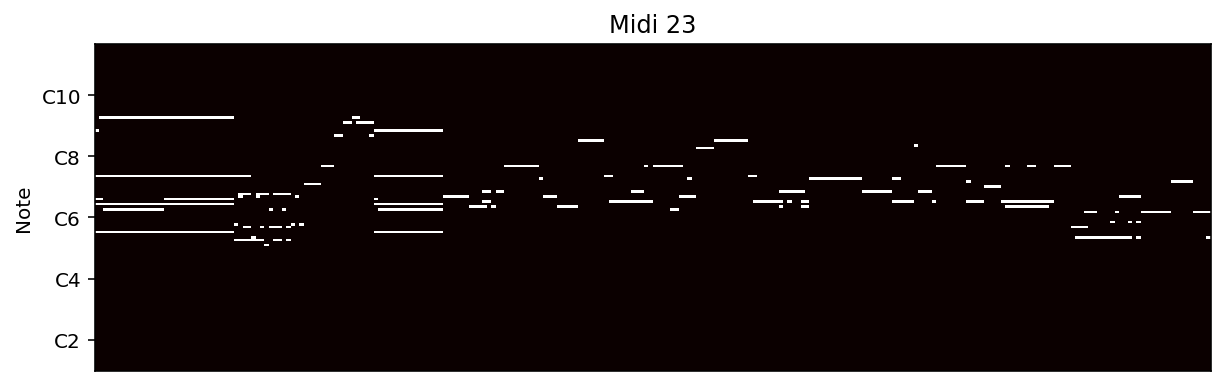

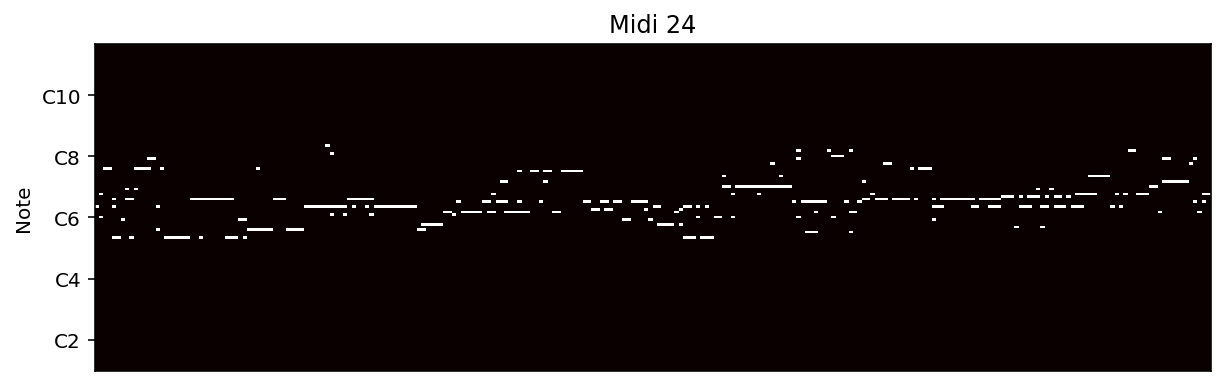

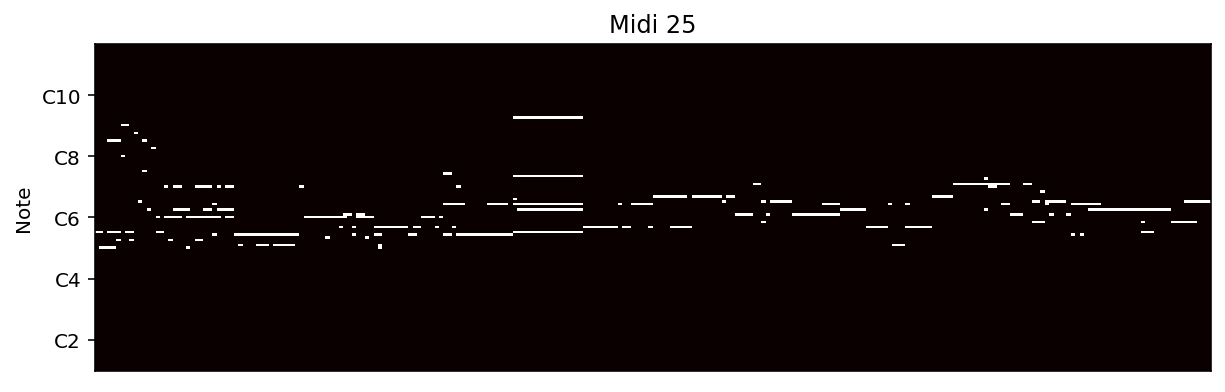

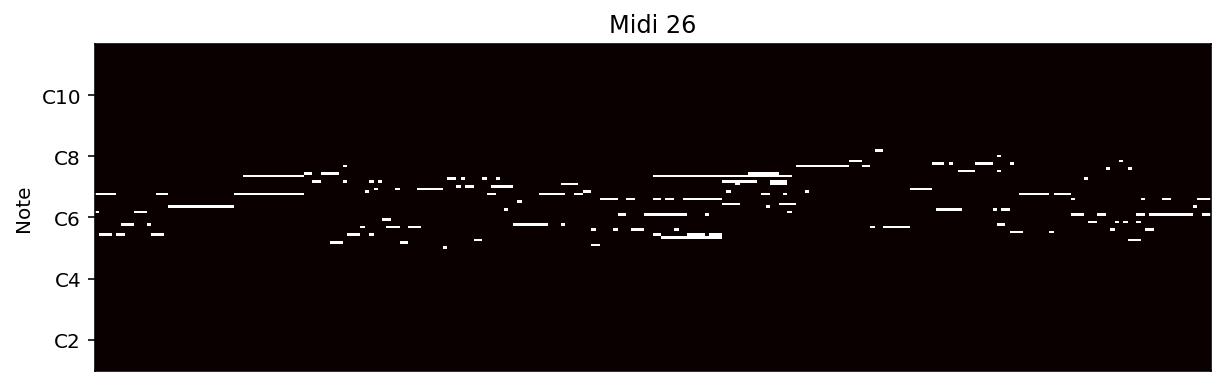

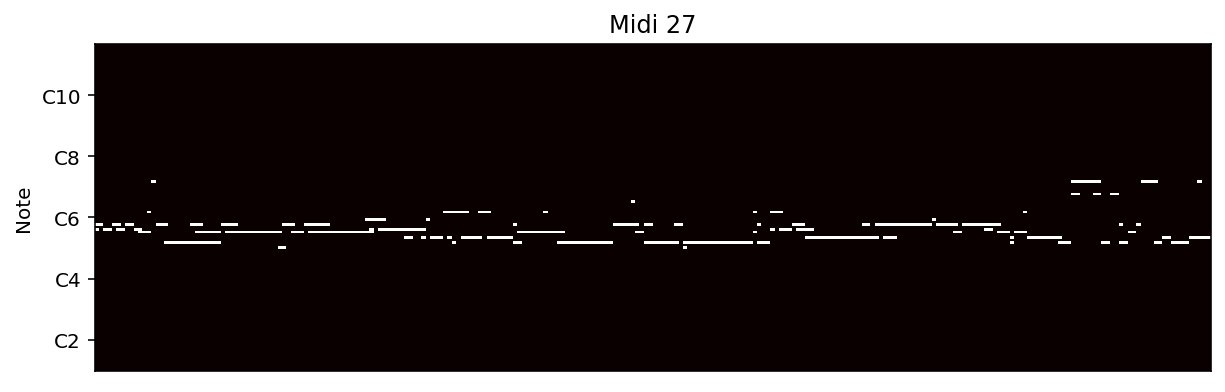

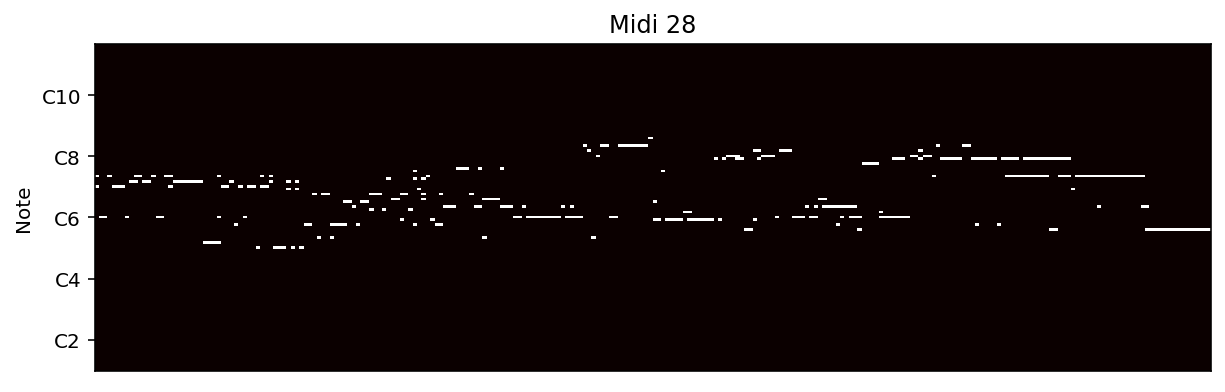

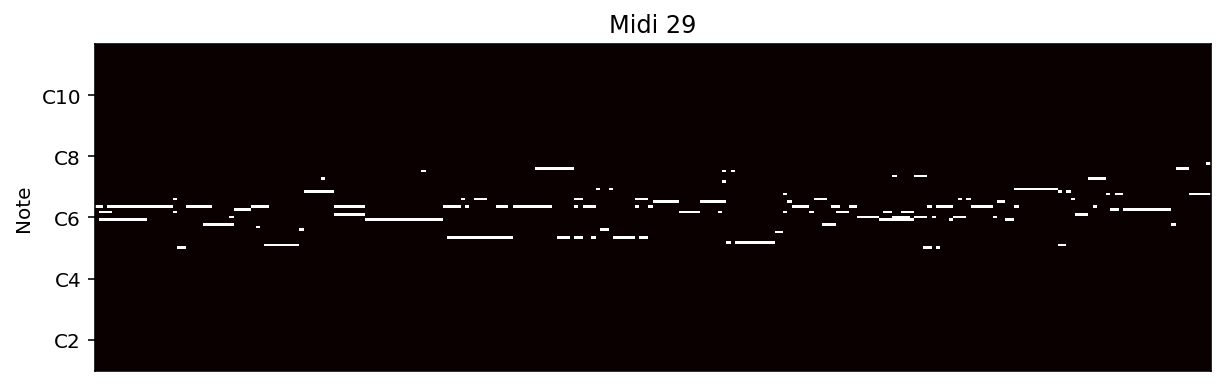

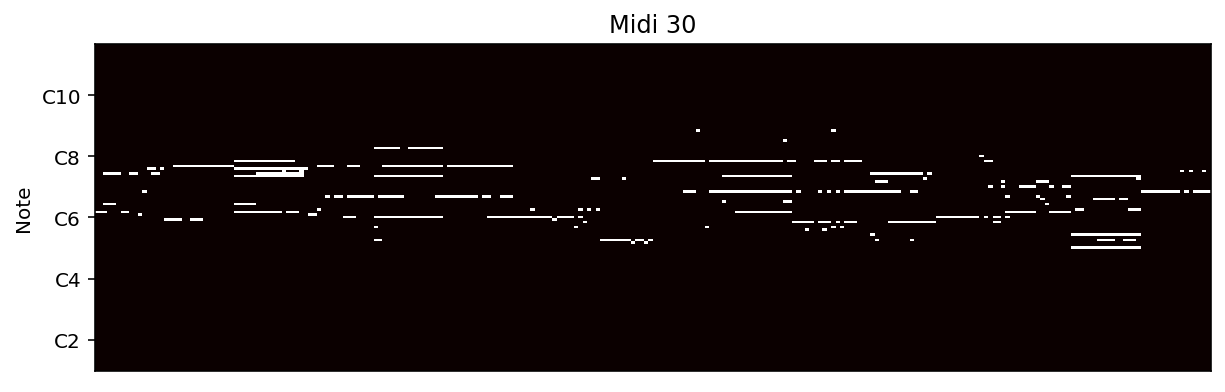

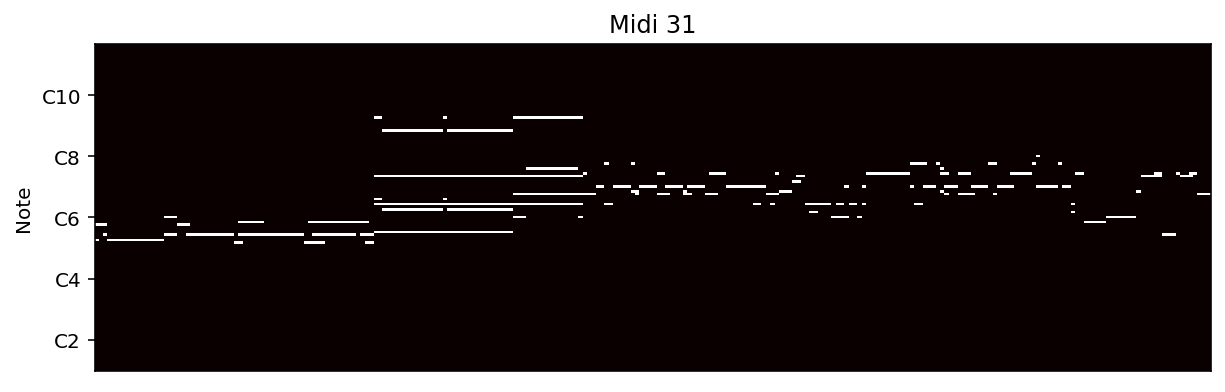

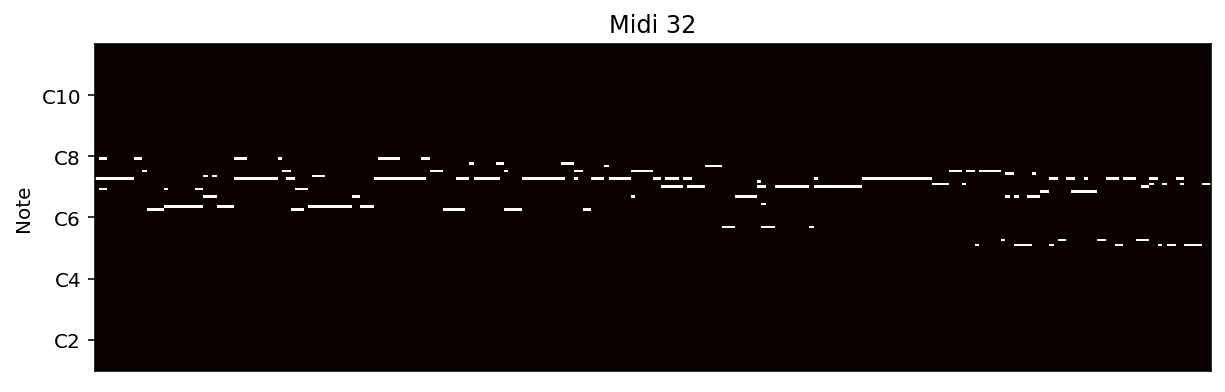

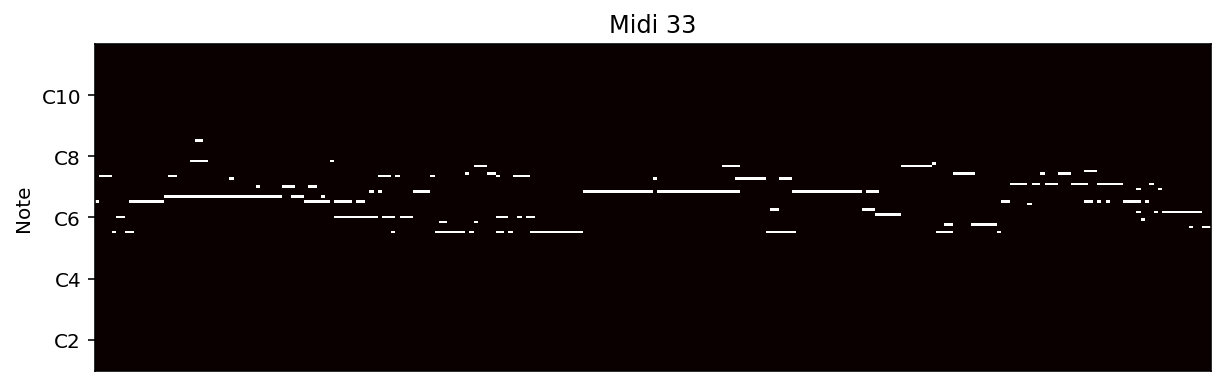

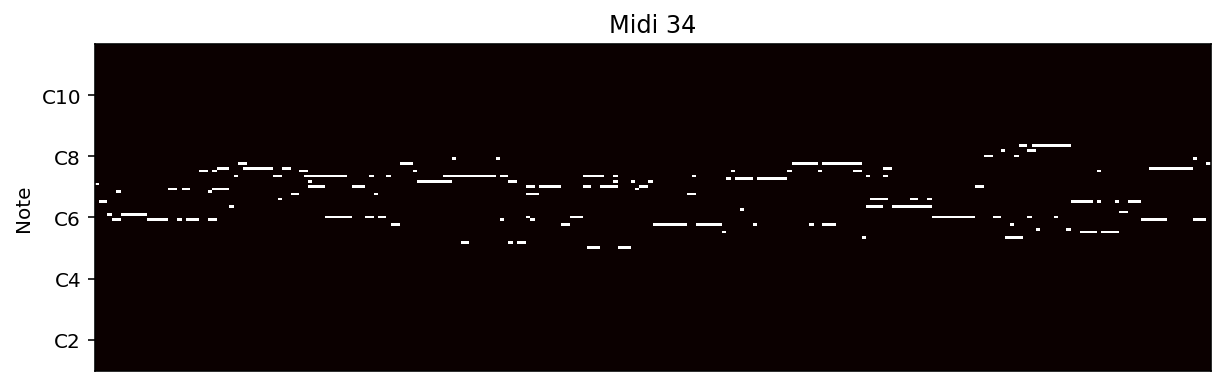

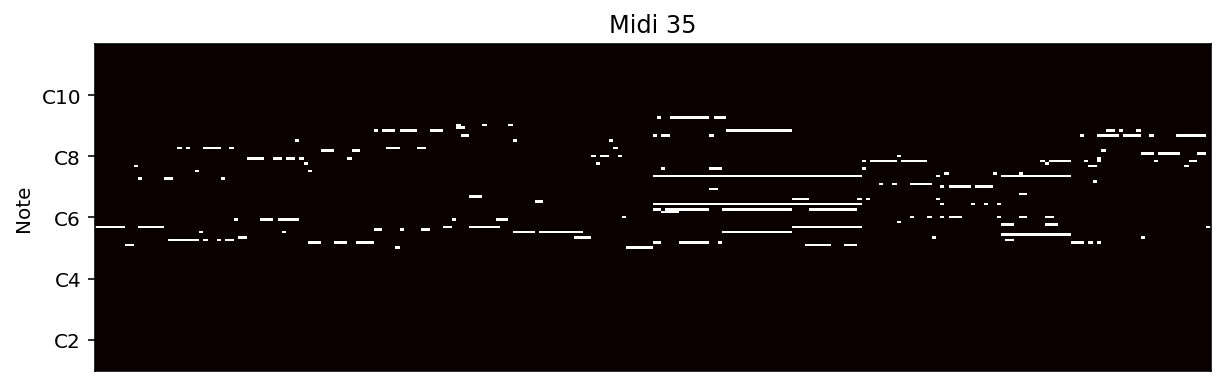

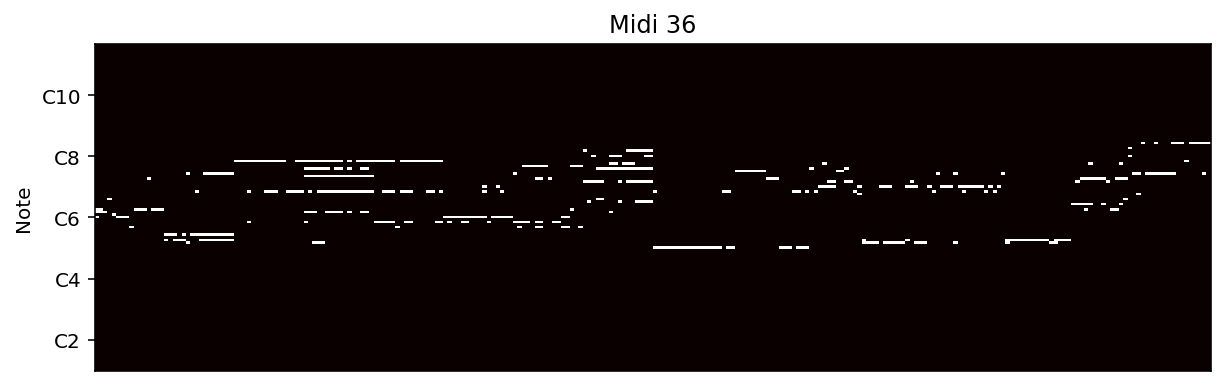

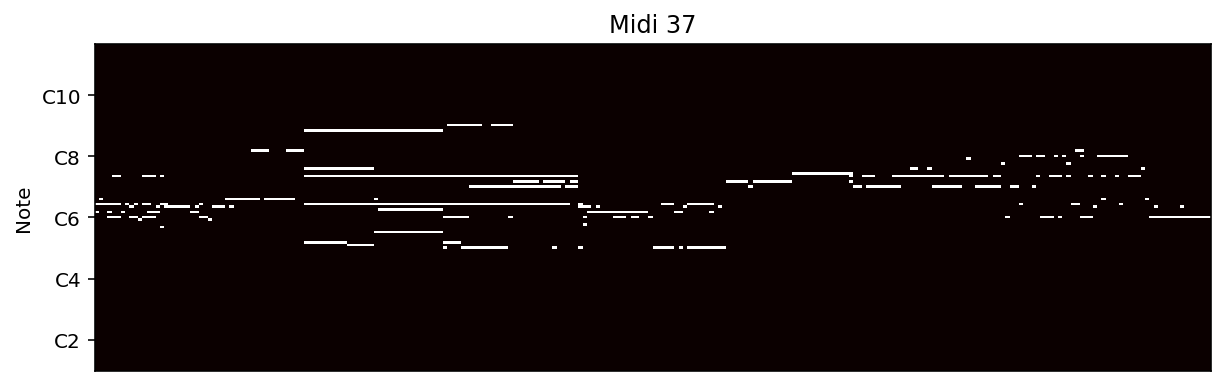

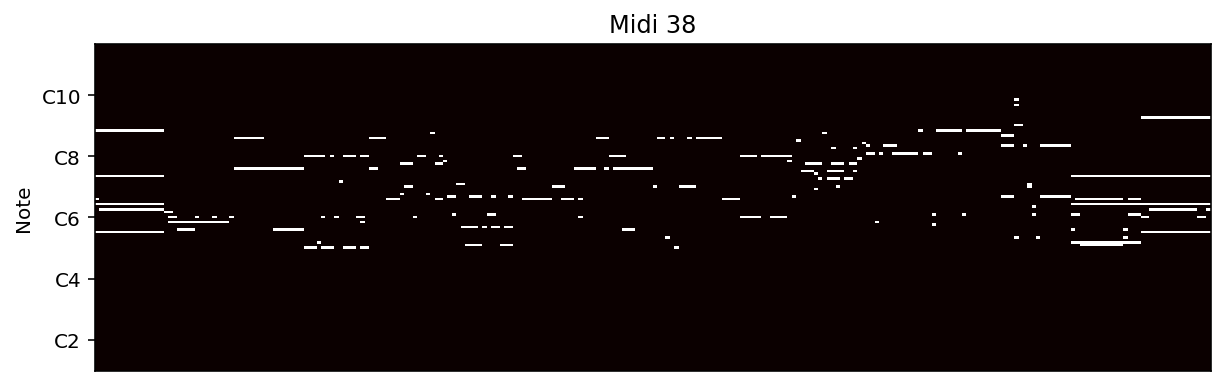

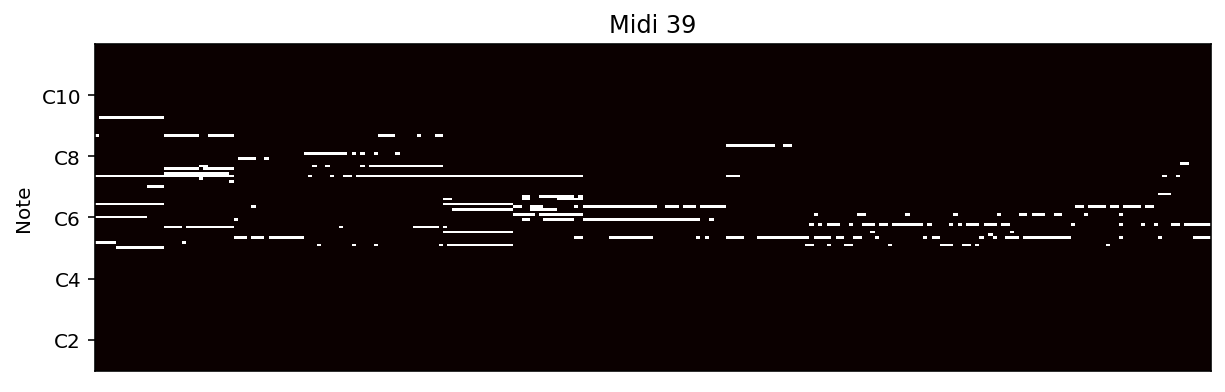

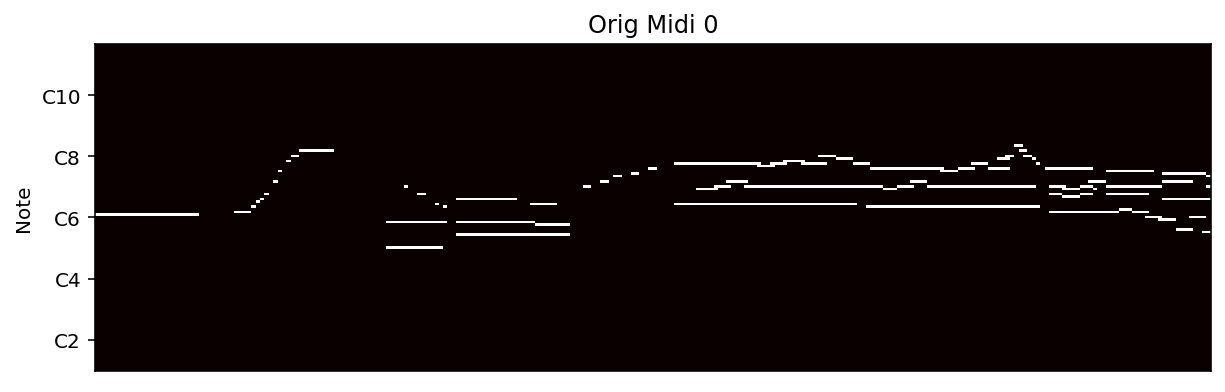

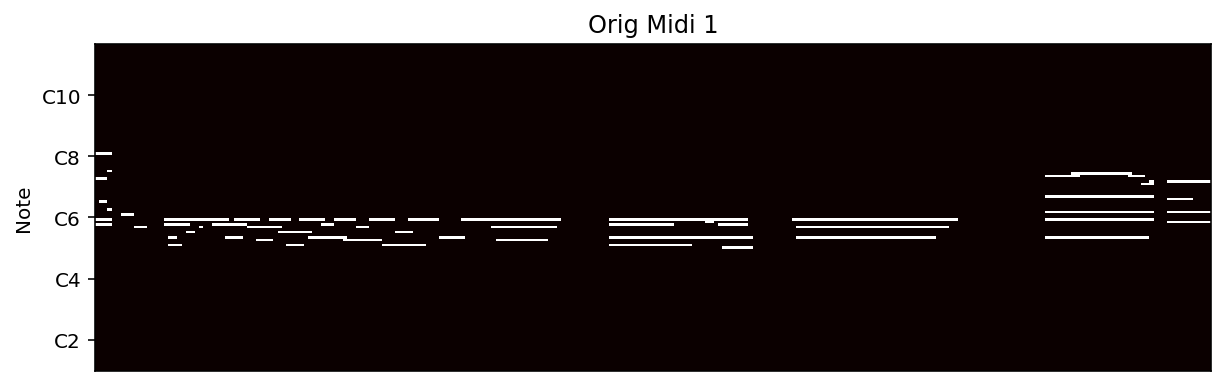

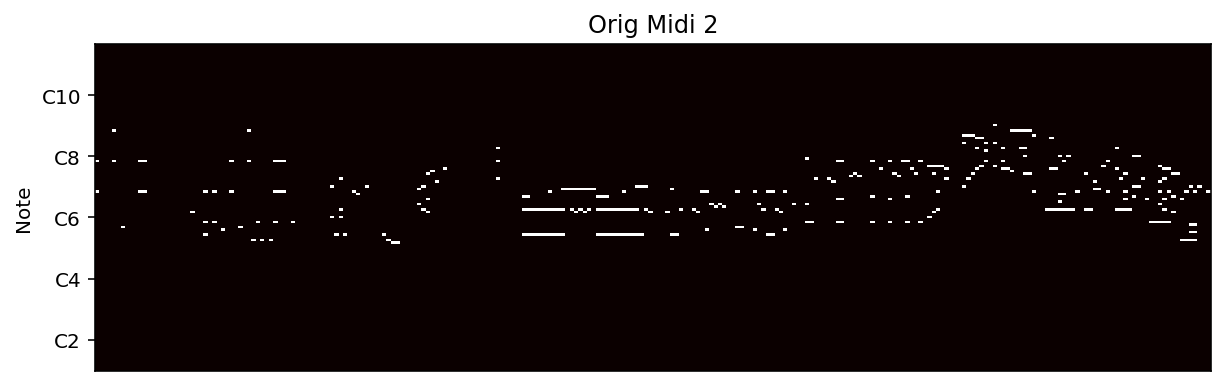

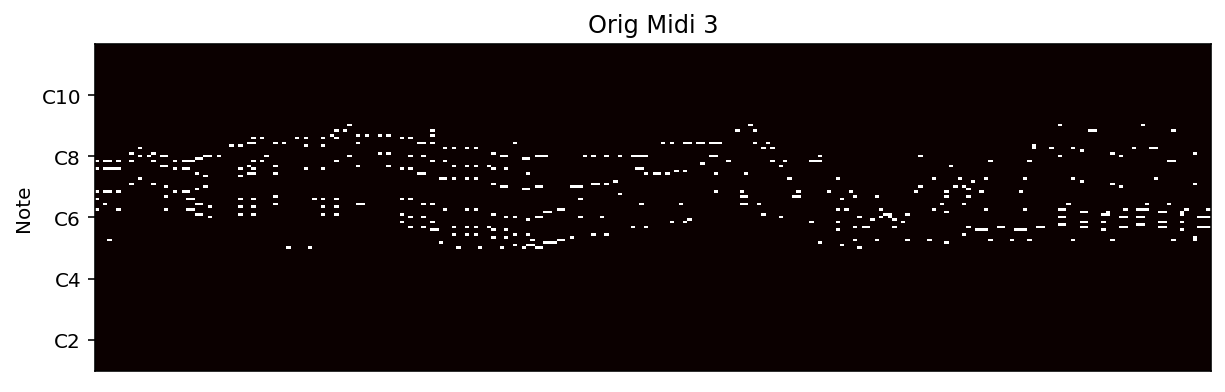

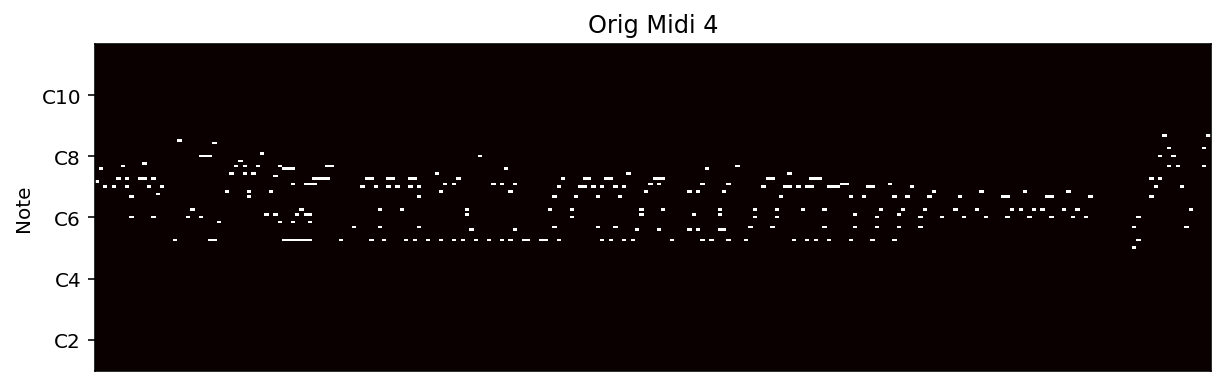

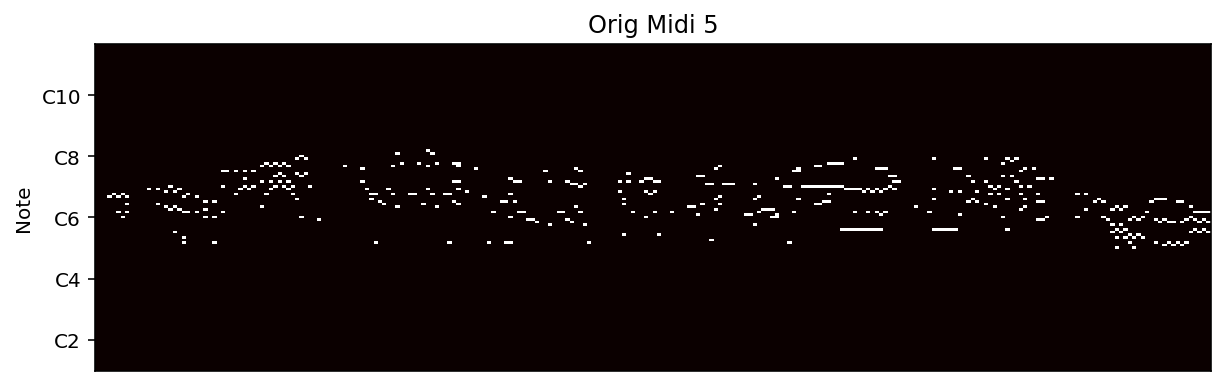

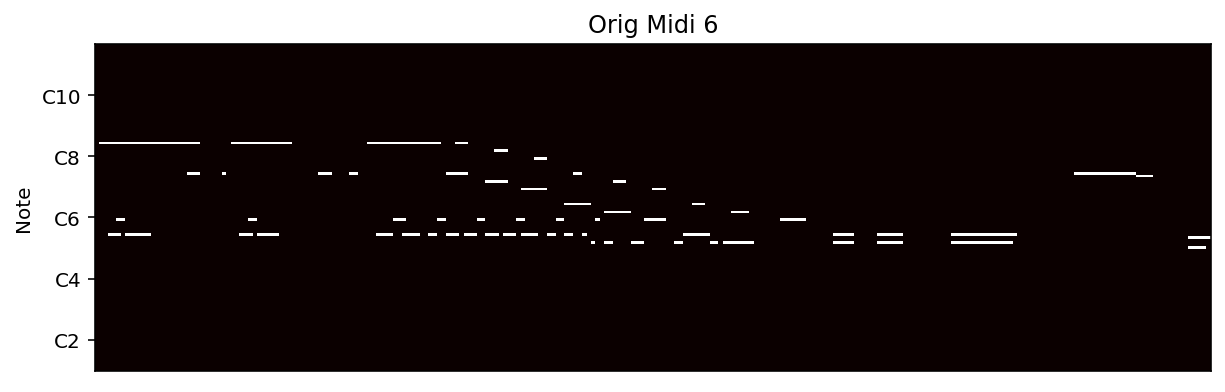

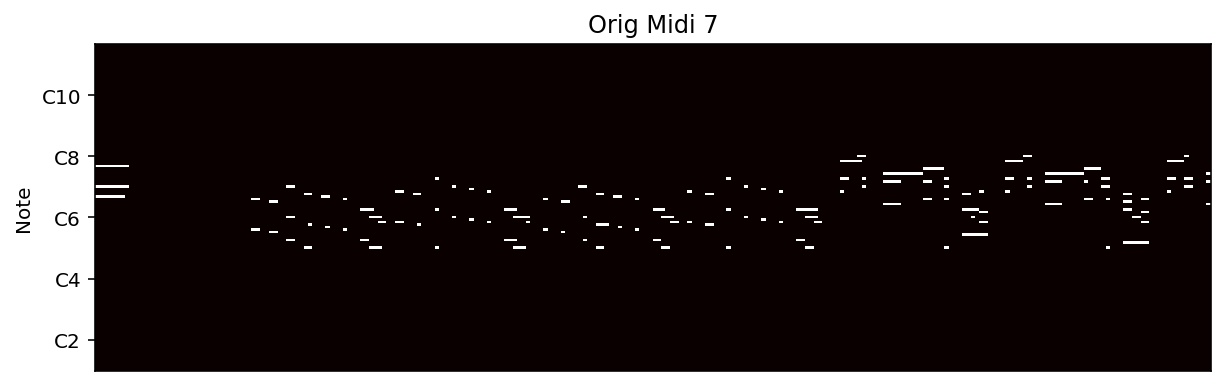

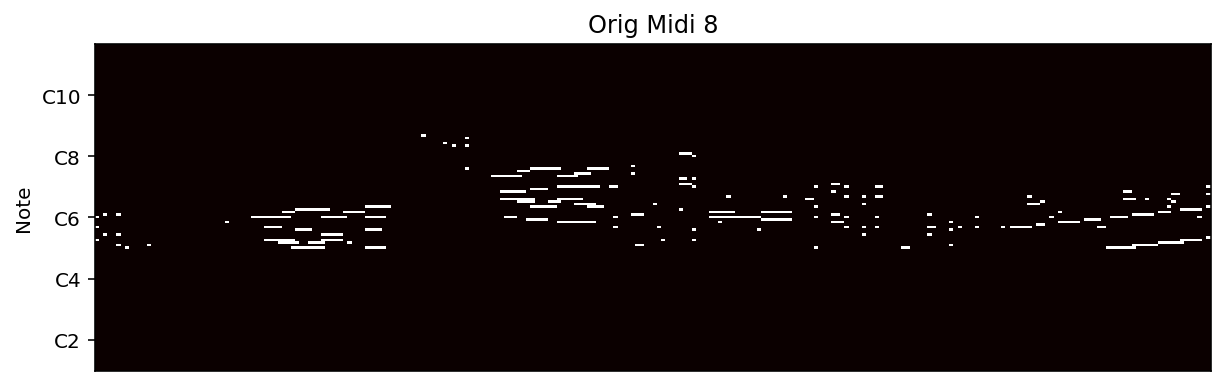

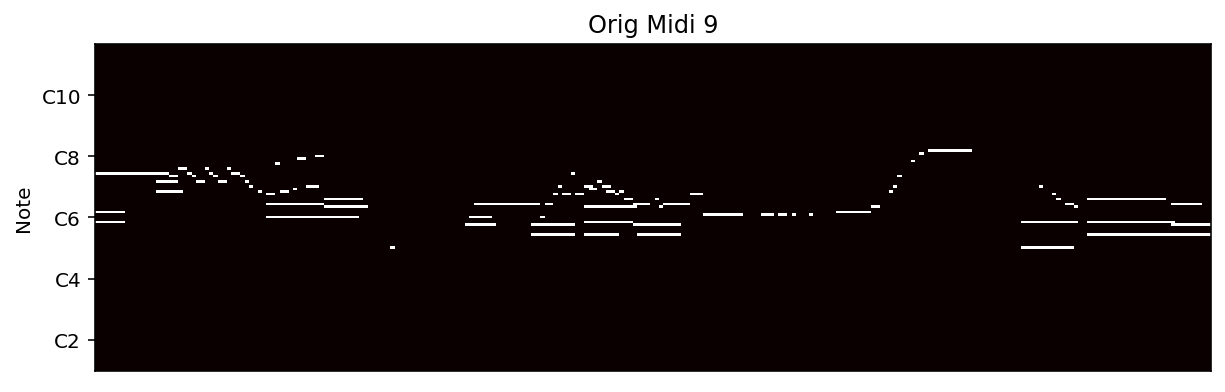

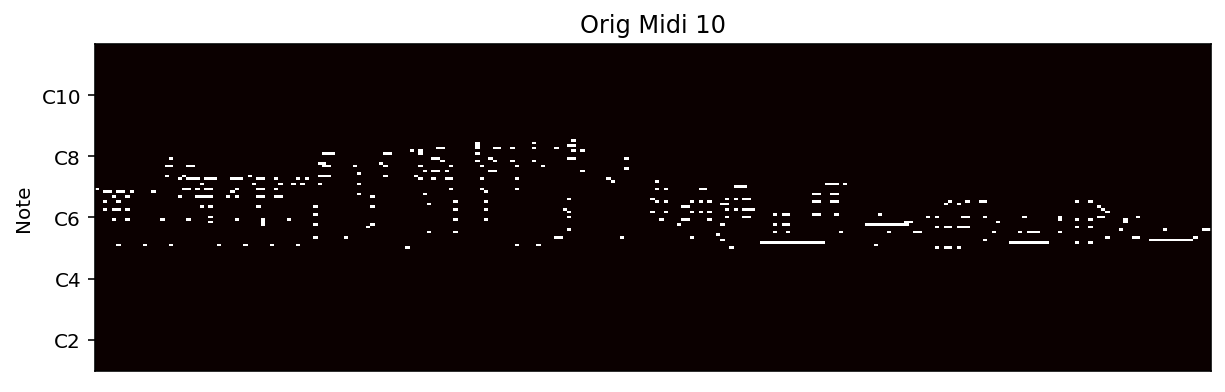

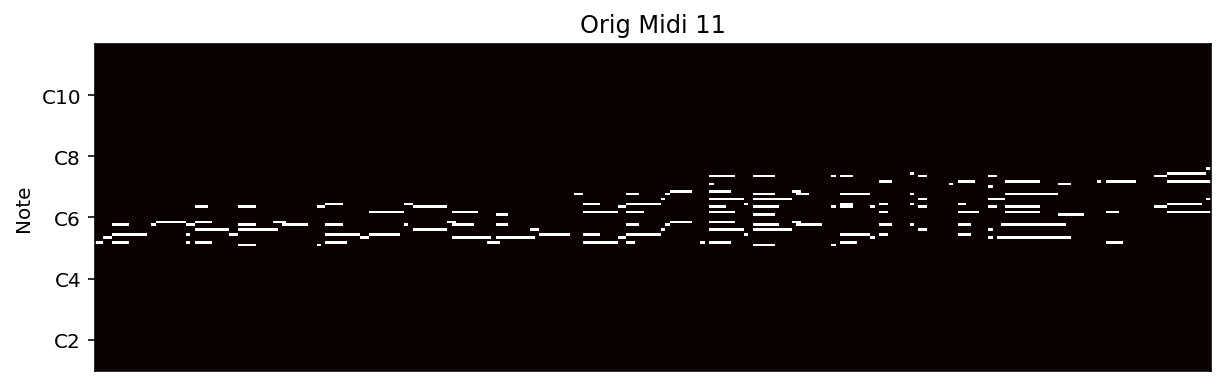

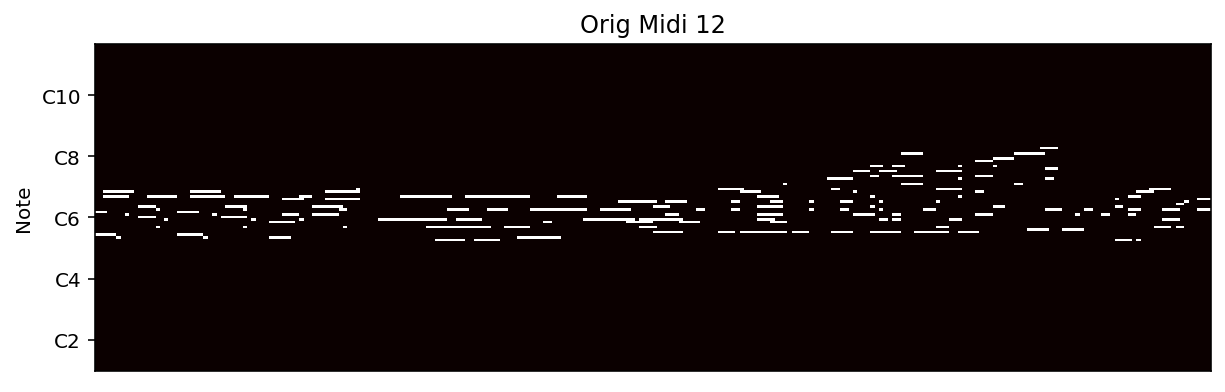

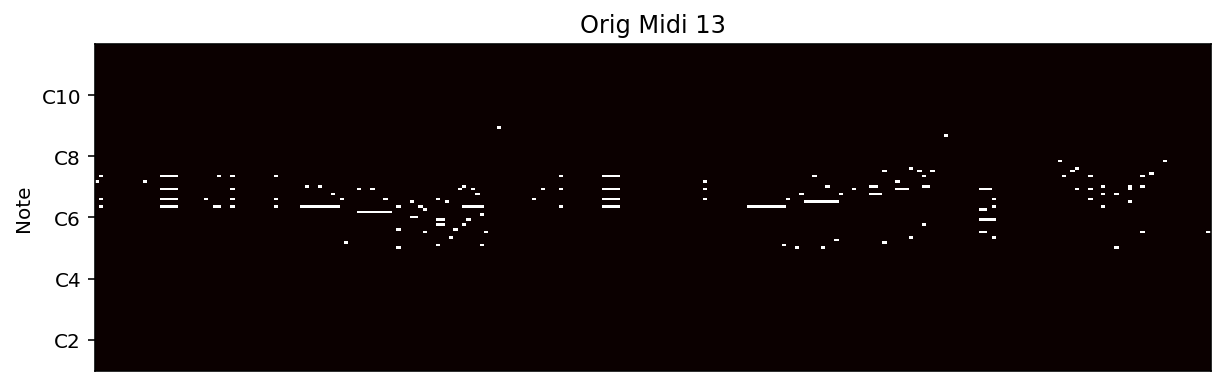

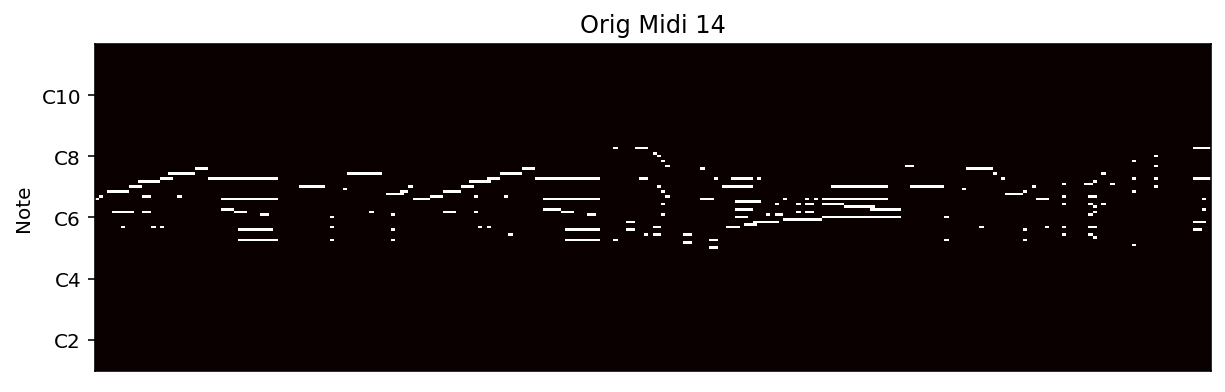

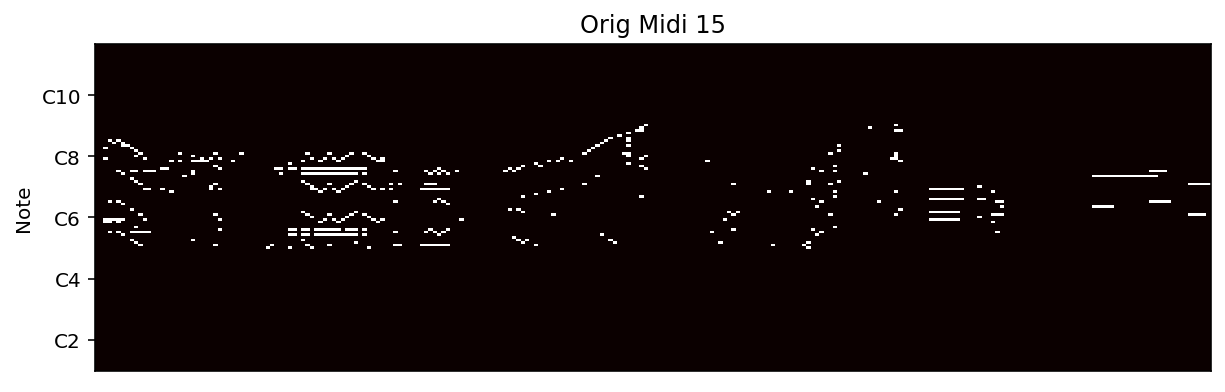

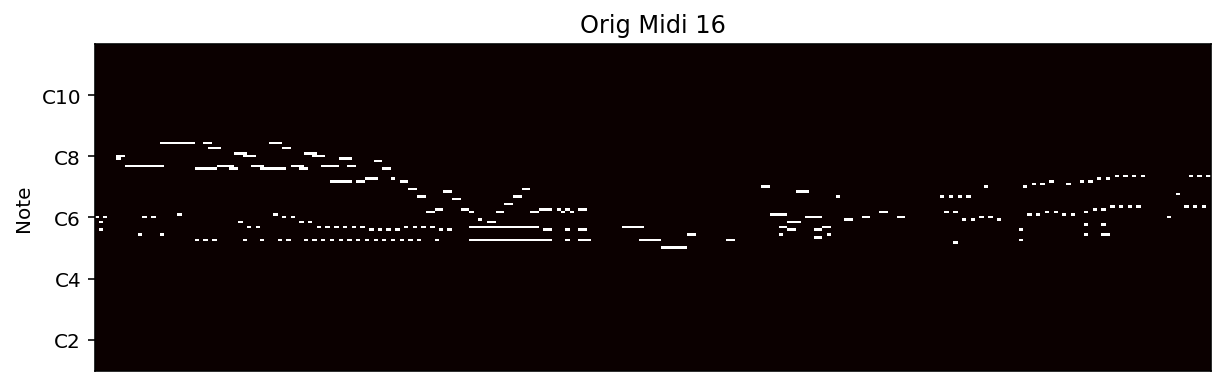

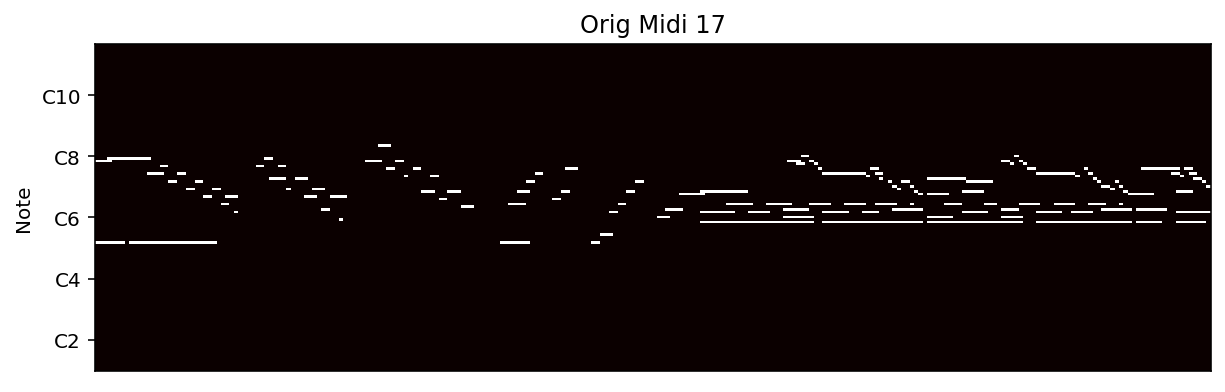

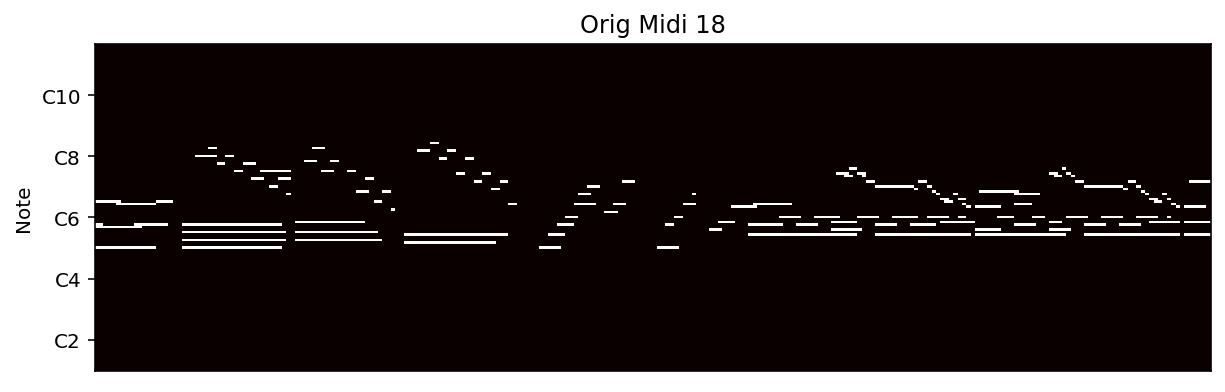

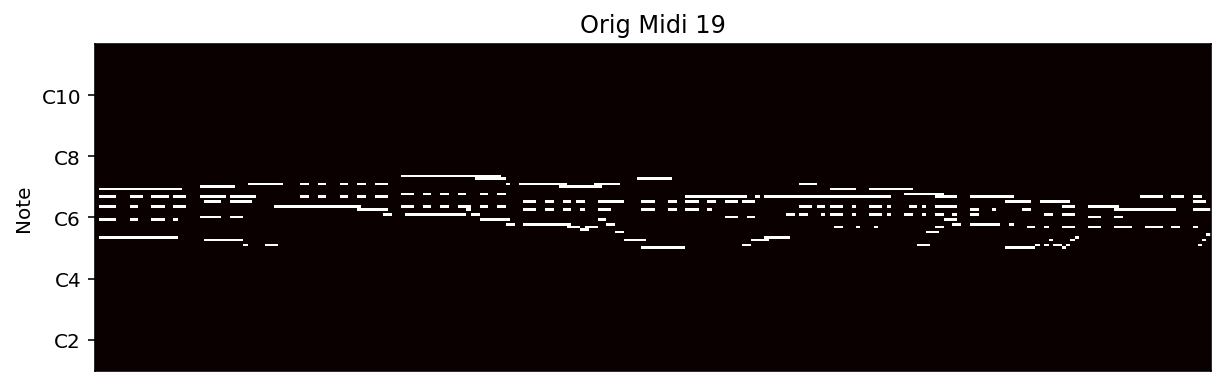

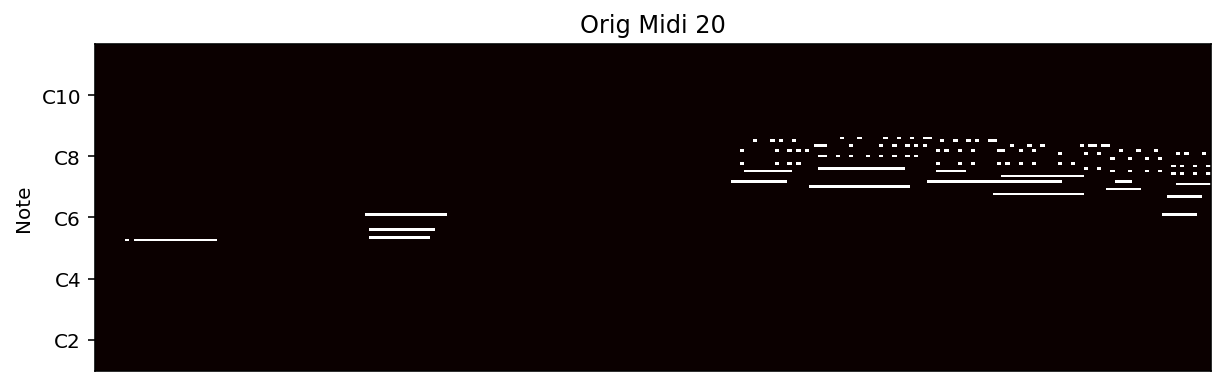

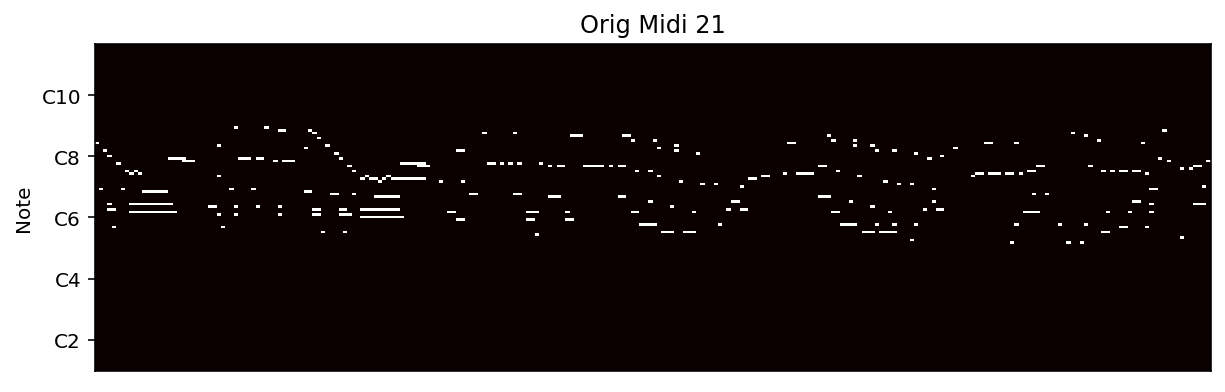

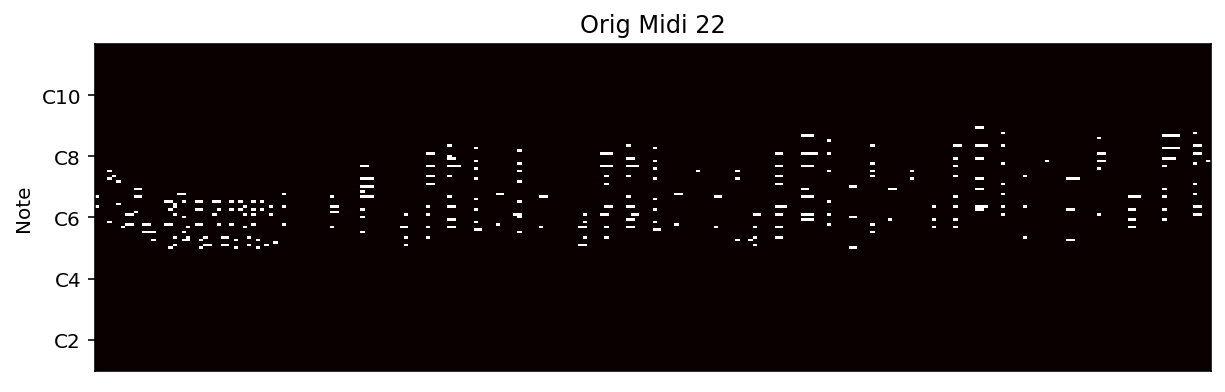

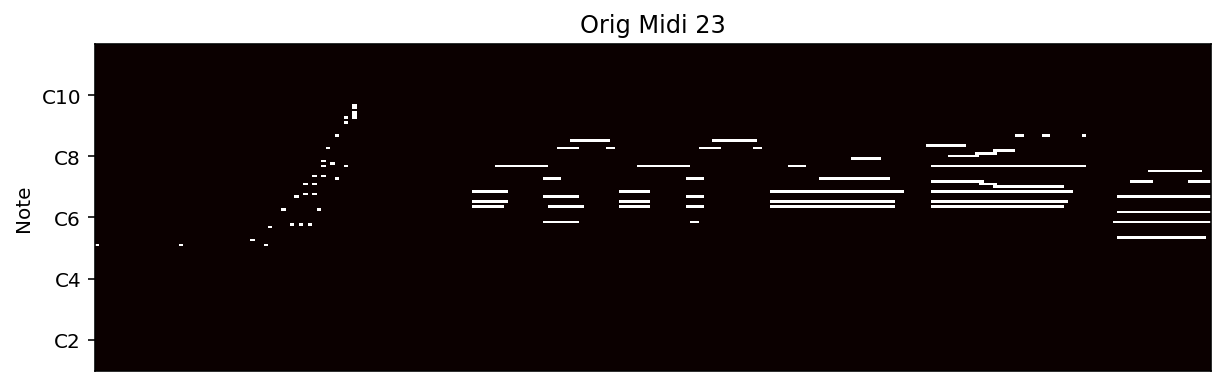

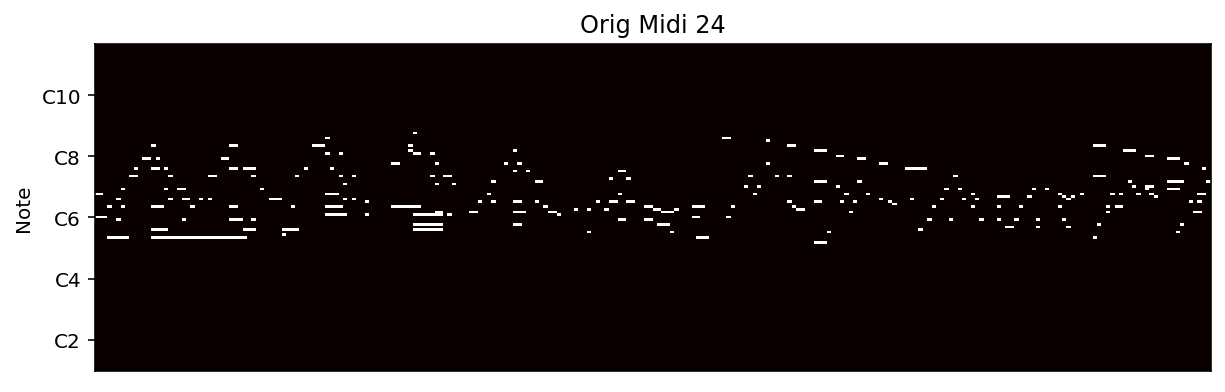

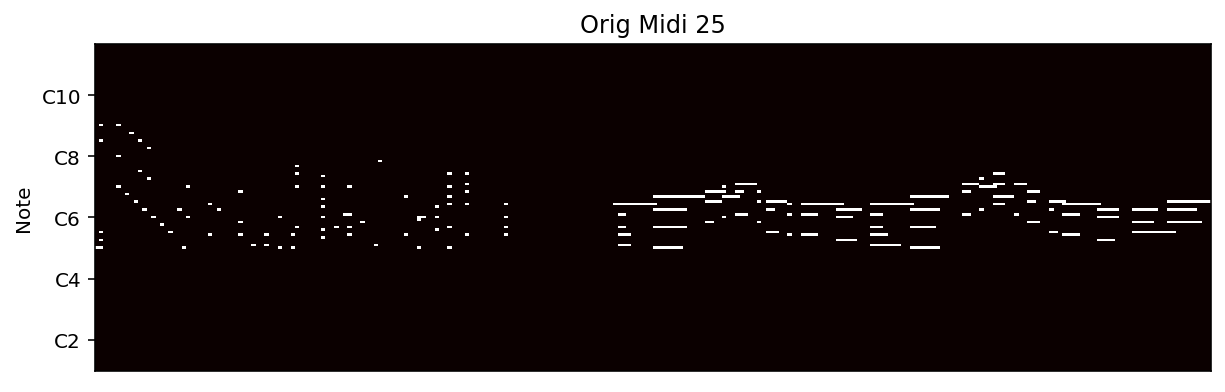

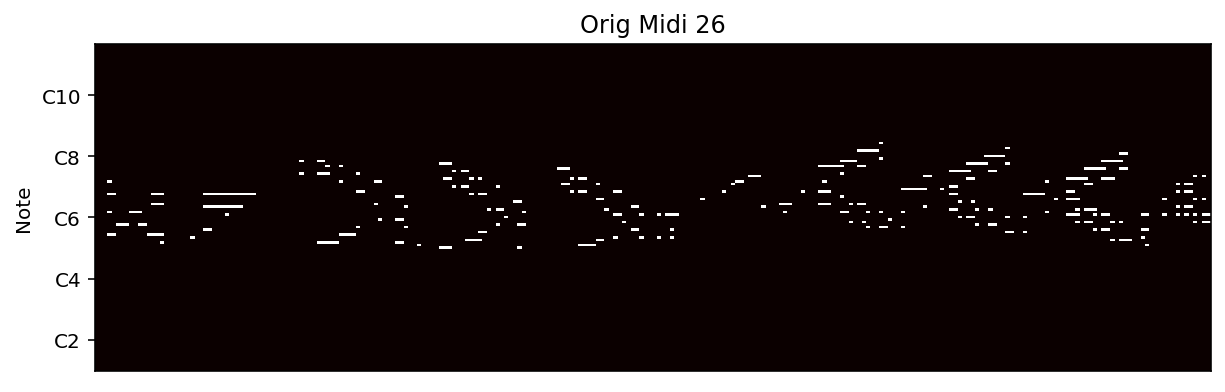

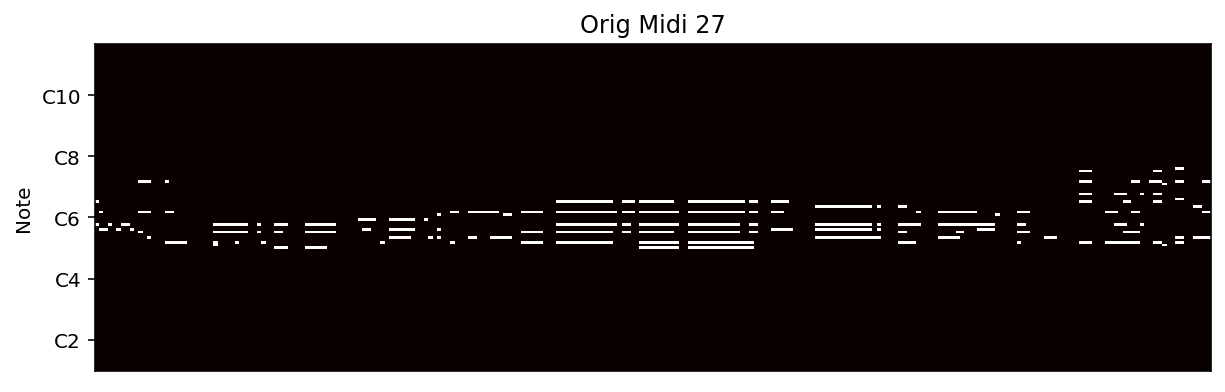

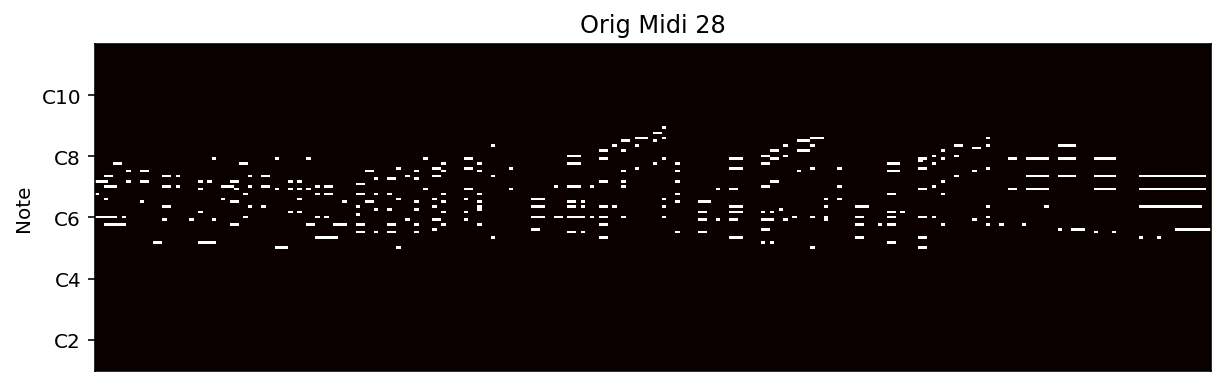

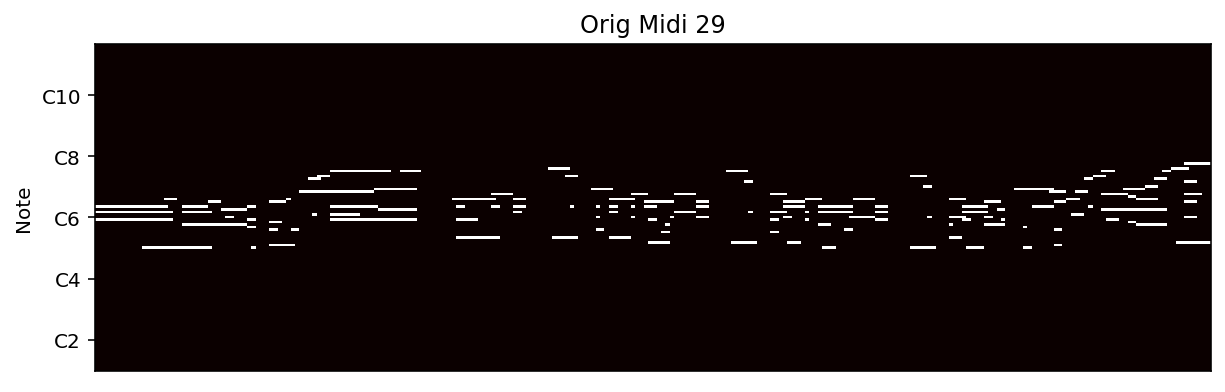

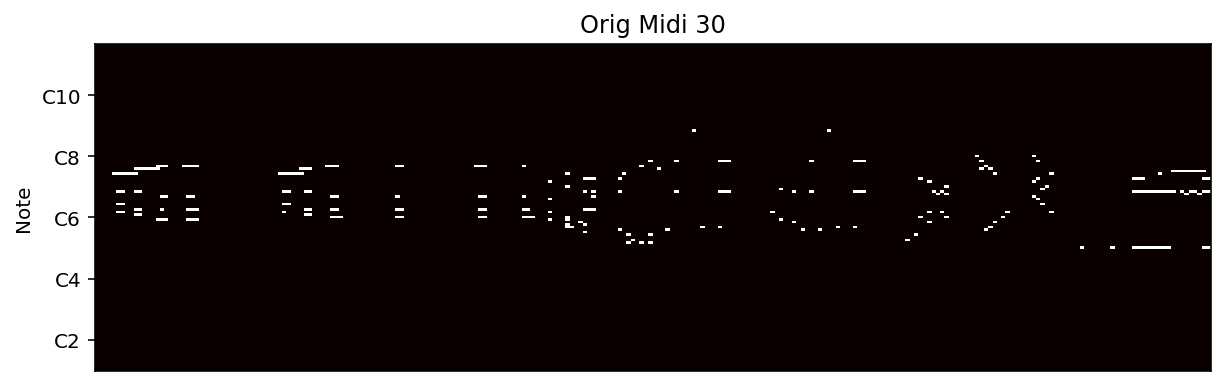

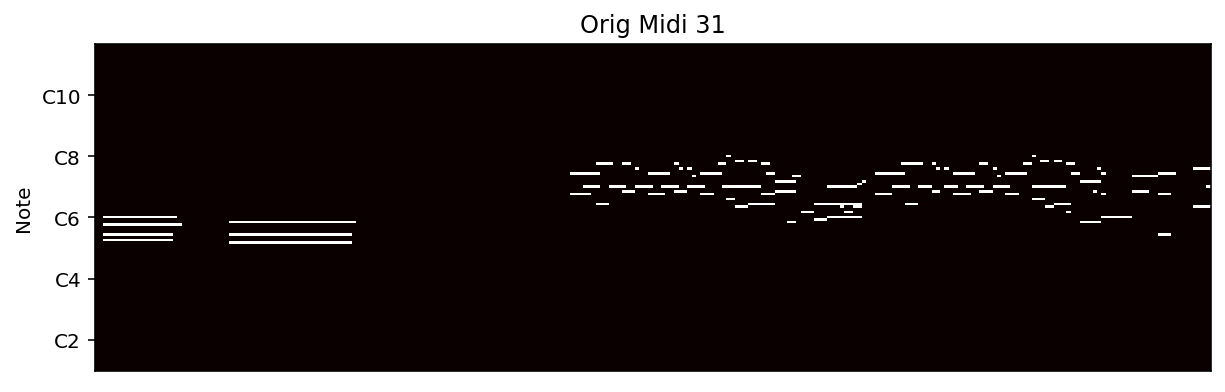

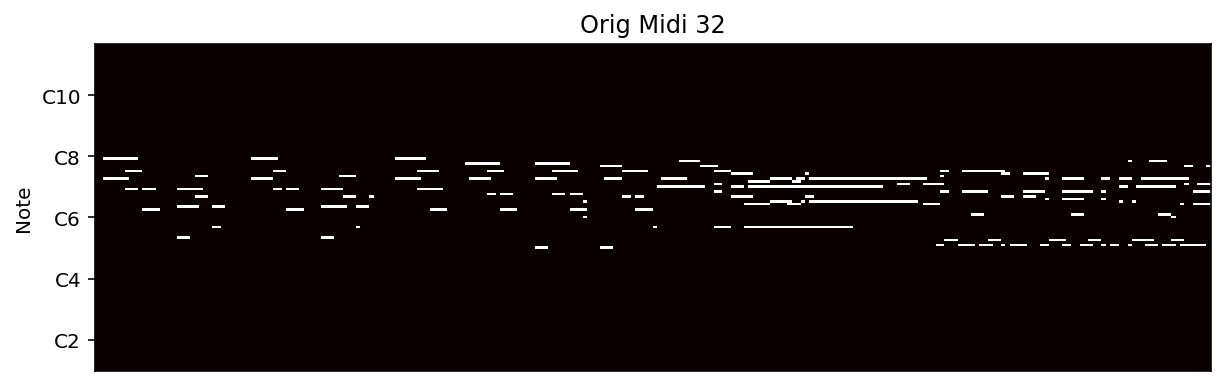

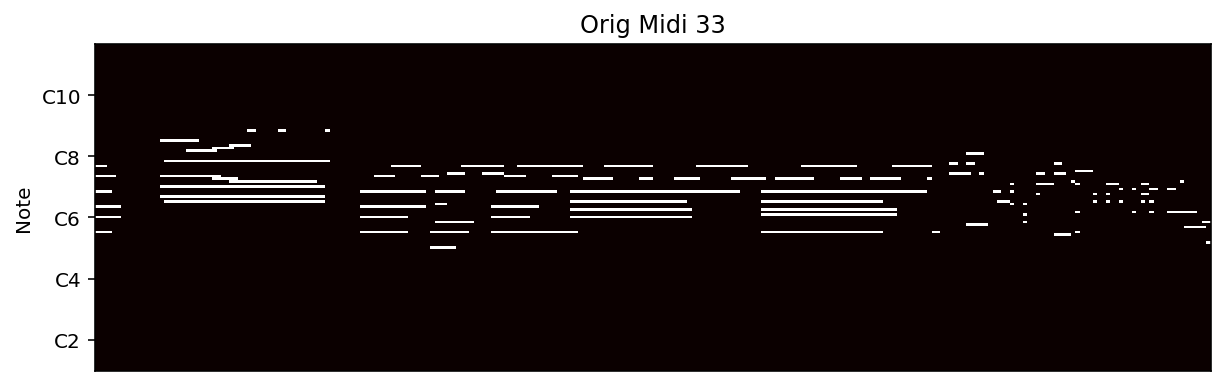

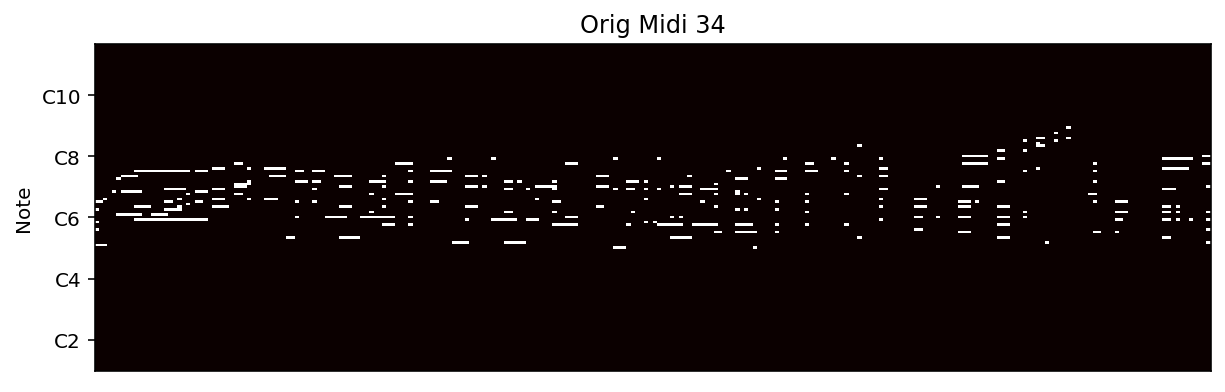

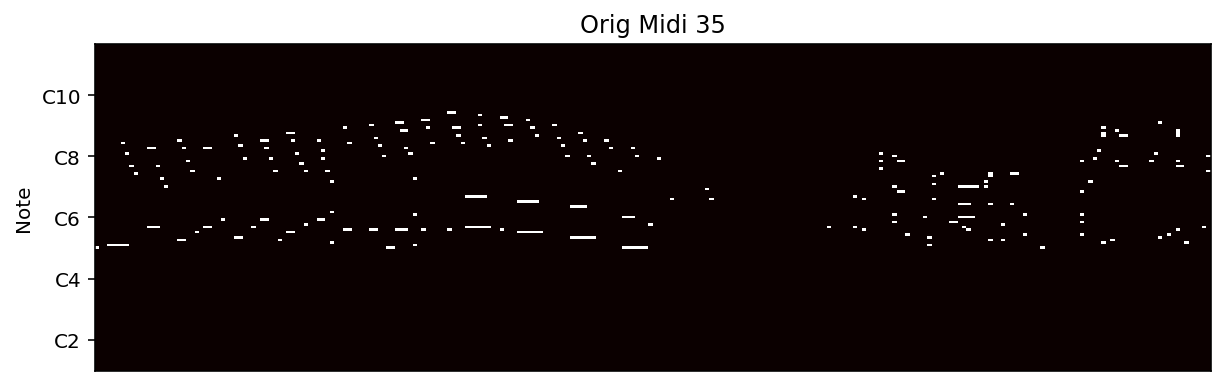

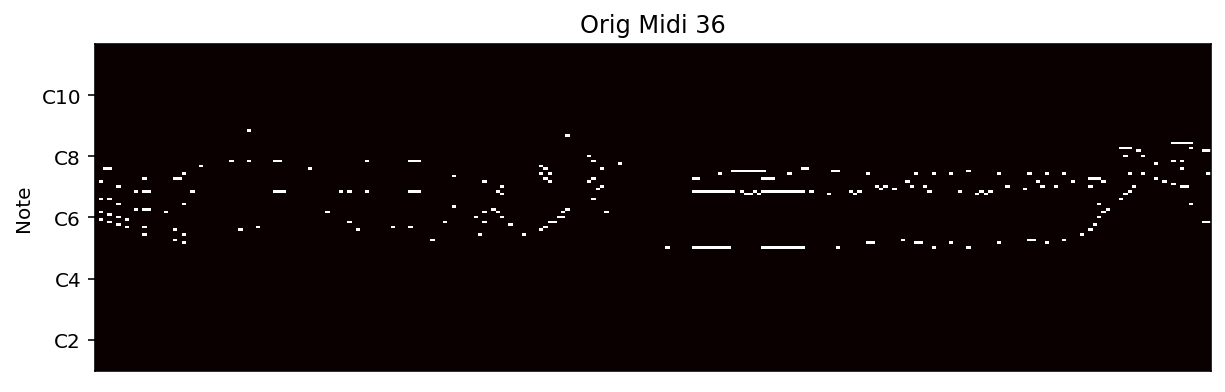

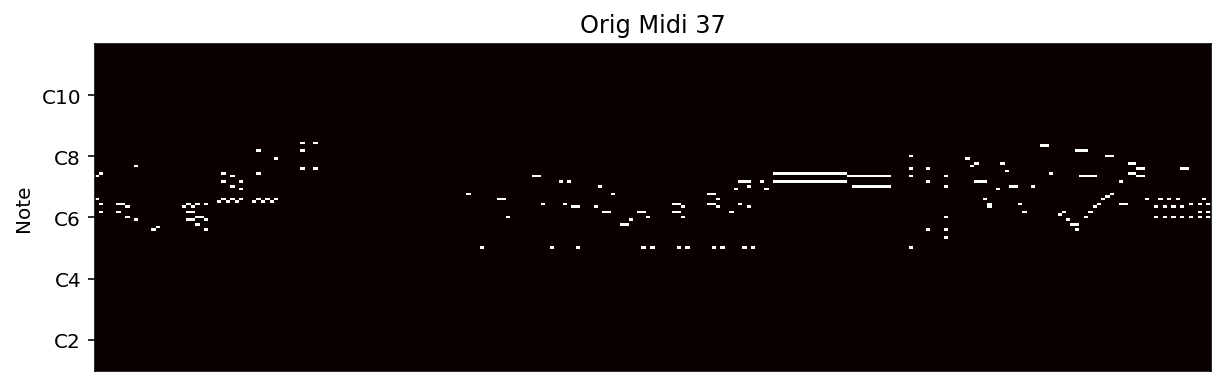

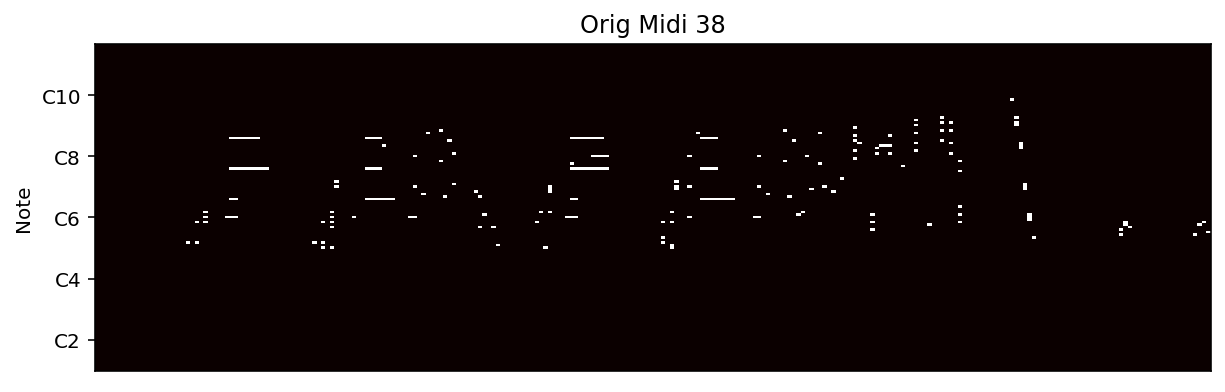

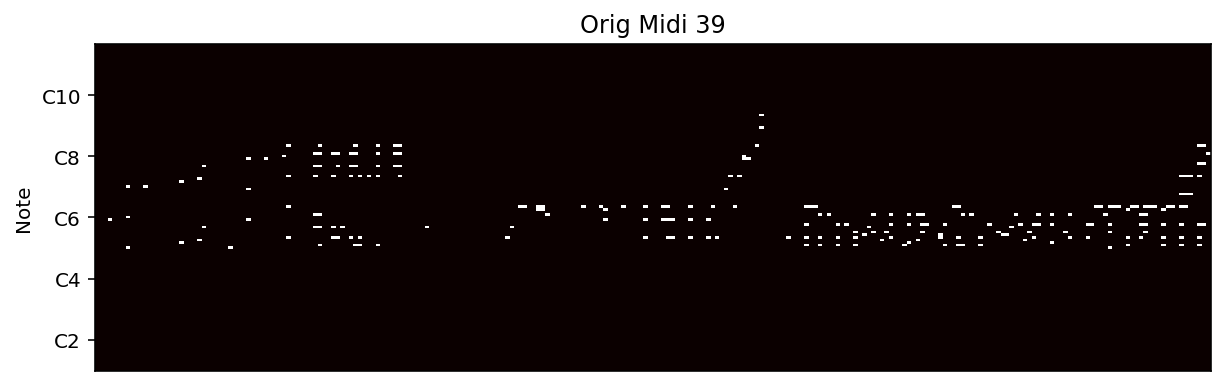

In [23]:
showReconstructionsMultiNotes(x_hat, x)